In [4]:
import numpy as np
import os
import time
import scipy
import glob
import sys
from datetime import datetime

import pandas as pd
import scipy.stats as sts

import matplotlib as mpl
mpl.use('nbagg')
import seaborn as sns
import pylab as pl

import importlib
# import some custom funcs
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import utils as util
import behavior as butil
import google_drive as gdrive

In [5]:
util.set_sns_style(style='dark')
%matplotlib.notebook

UsageError: Line magic function `%matplotlib.notebook` not found.


In [6]:
rootdir='/Users/julianarhee/Library/CloudStorage/GoogleDrive-edge.tracking.ru@gmail.com/My Drive/Edge_Tracking/Data'
rootdir = rootdir.replace('Data', 'Analysis')
#root_dir = os.path.join(root_dir, 'jyr')
#experiment = 'vertical_strip/paired_experiments' 
experiment = '0-degree' 
# experiment = 'reverse gradient' 

strip_width = 50
strip_sep = 200
fig_id = os.path.join(rootdir.split('/My Drive')[1], experiment)
srcdir = os.path.join(rootdir, experiment)
save_basedir = '/Users/julianarhee/Documents/rutalab/data/gdrive'
savedir = os.path.join(save_basedir, 'all-vertical-strip')
savedir = savedir.replace(" ", "")
figdir = os.path.join(savedir, 'figures')
print("Saving figures to:{}    {}".format('\n', figdir))
if not os.path.exists(figdir):
    os.makedirs(figdir)

Saving figures to:
    /Users/julianarhee/Documents/rutalab/data/gdrive/all-vertical-strip/figures


In [7]:
importlib.reload(gdrive)
importlib.reload(butil)

<module 'behavior' from '/Users/julianarhee/Repositories/plume-tracking/behavior.py'>

In [8]:
experiment_list = ['Spontaneous_edge_tracking', '0-degree']
dlist=[]; fly_ids=[];
for experiment in experiment_list:
    log_files, logdf = butil.get_log_files(experiment=experiment, 
                                return_loginfo=True,
                                verbose=False, rootdir=rootdir, is_gdrive=True)
    # # Load dataframes
    df_ = butil.load_combined_df(log_files=log_files, logdf=logdf, experiment=experiment,
                                 save=False, savedir=None, verbose=False, parse_filename=True,
                                 create_new=True, remove_invalid=True, process=True,
                                 rootdir=rootdir)
    curr_savefpath = '{}/{}/combined_df.pkl'.format(save_basedir, experiment)
    print(curr_savefpath)
    butil.save_df(df_, curr_savefpath)
    dlist.append(df_[~df_['fly_id'].isin(fly_ids)])
    fly_ids.extend(df_['fly_id'].unique())
df0_all =pd.concat(dlist)

COMPLETE: Data copied
Checking Data dir instead of Analysis
12 of 13 files found in: /Users/julianarhee/Library/CloudStorage/GoogleDrive-edge.tracking.ru@gmail.com/My Drive/Edge_Tracking/Data/Spontaneous_edge_tracking
Processing 12 tracking files.
Correcting experiment conditions: /Users/julianarhee/Library/CloudStorage/GoogleDrive-edge.tracking.ru@gmail.com/My Drive/Edge_Tracking/Data/Spontaneous_edge_tracking
/Users/julianarhee/Documents/rutalab/data/gdrive/Spontaneous_edge_tracking/combined_df.pkl
COMPLETE: Data copied
50 of 50 files found in: /Users/julianarhee/Library/CloudStorage/GoogleDrive-edge.tracking.ru@gmail.com/My Drive/Edge_Tracking/Analysis/0-degree/logs
Processing 50 tracking files.
[WARNING] 08192020-203059_0degOdor: Found bad skips, removing 18147 of 23593 samples.
--> found bad skips in FTs, check: 08192020-203059_0degOdor
[WARNING] 08242020-211008_0degOdor: Found bad skips, removing 92 of 43154 samples.
--> found bad skips in FTs, check: 08242020-211008_0degOdor
[WA

In [9]:
importlib.reload(butil)

<module 'behavior' from '/Users/julianarhee/Repositories/plume-tracking/behavior.py'>

In [10]:
print("Curret dataset experiments: {}".format(df0_all['experiment'].unique()))
print("Curret dataset conditions: {}".format(df0_all['condition'].unique()))

Curret dataset experiments: ['Spontaneous_edge_tracking' '0-degree']
Curret dataset conditions: ['spontaneous' 'not_reinforced' 'reinforced' '0']


In [11]:
condition_list = ['0', 'spontaneous', 'not_reinforced']
df0 = df0_all[df0_all['condition'].isin(condition_list)].copy()

In [12]:
odor_df = pd.concat([df_.loc[df_[df_['instrip']].iloc[0].name:] for trial_id, df_ \
             in df0.groupby('trial_id')])

In [13]:
# for trial_id, df_ in df0.groupby('trial_id'):
#     print(trial_id, df_.loc[df_[df_['instrip']].iloc[0].name:].shape)

In [14]:
len(odor_df['trial_id'].unique())


35

In [17]:
%matplotlib notebook

In [18]:
fig = butil.plot_all_flies(odor_df, col_wrap=7)
figname = 'traj-all-flies'
pl.savefig(os.path.join(figdir, '{}.png'.format(figname)))

<IPython.core.display.Javascript object>

# 1 fly

In [19]:
# def find_crossovers(df_, strip_width=50):
#     crossover_bouts = [bnum for bnum, b_ in df_[df_['instrip']].groupby('boutnum') \
#                          if np.ceil(b_['ft_posx'].max() - b_['ft_posx'].min()) >= strip_width]
#     return crossover_bouts

importlib.reload(butil)

<module 'behavior' from '/Users/julianarhee/Repositories/plume-tracking/behavior.py'>

In [20]:
def get_longest_run(df_):
    entered_left, entry_df = butil.check_entry_left_edge(df_, entry_ix=None, 
                                                     only_upwind_outbouts=False, return_bool=True)
    # count N crossovers and max run length
    max_entries = entry_df.groupby('consecutive_bout')['consecutive_count'].max()
    if len(max_entries)==0:
        return None, None
    
    n_crossovers = max_entries.shape[0]-1
    most_reentries = max_entries.max()+1
    print("{}: {} crossovers, {} reentries at max".format(trial_id, n_crossovers, most_reentries))

    # Extract the longest run bout
    max_consecutive_boutnum = max_entries.idxmax()
    bouts_in_run = entry_df[entry_df['consecutive_bout']==max_consecutive_boutnum]
    bout_range = bouts_in_run['previous_outbout'].min(), bouts_in_run['previous_outbout'].max()
    if df_['boutnum'].max() > bout_range[-1]:
        incl_boutnums = np.arange(bout_range[0], bout_range[1]+1) # also include next outbout
    else:
        incl_boutnums = np.arange(bout_range[0], bout_range[1]) 
    rundf = df_[df_['boutnum'].isin(incl_boutnums)].copy()
    return rundf, entry_df

def get_n_crossovers_and_entries(entry_df):
    if len(entry_df)==0:
        return 0, 0
    max_entries = entry_df.groupby('consecutive_bout')['consecutive_count'].max()
    n_crossovers = max_entries.shape[0]-1
    most_reentries = max_entries.max()+1
    print("{}: {} crossovers, {} reentries at max".format(trial_id, n_crossovers, most_reentries))
    return n_crossovers, most_reentries

In [21]:
if not os.path.exists(os.path.join(figdir, 'individuals')):
    os.makedirs(os.path.join(figdir, 'individuals'))

In [22]:
importlib.reload(butil)

<module 'behavior' from '/Users/julianarhee/Repositories/plume-tracking/behavior.py'>

In [23]:
trial_ids = sorted(df0['trial_id'].unique(), key=util.natsort)
# trial_ids

20200630-fly184740_06302020-184740: 2 crossovers, 47 reentries at max
20200630-fly184740_06302020-184740: 2 crossovers, 47 reentries at max


<IPython.core.display.Javascript object>

20200708-fly194358_07082020-194358: 1 crossovers, 23 reentries at max
20200708-fly194358_07082020-194358: 1 crossovers, 23 reentries at max


/var/folders/6z/bhycp6jj4pxg1qt6h_j36h880000gn/T/ipykernel_52710/1550300882.py:40: MatplotlibDeprecationWarning: The close_event function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use callbacks.process('close_event', CloseEvent(...)) instead.
  pl.close()


<IPython.core.display.Javascript object>


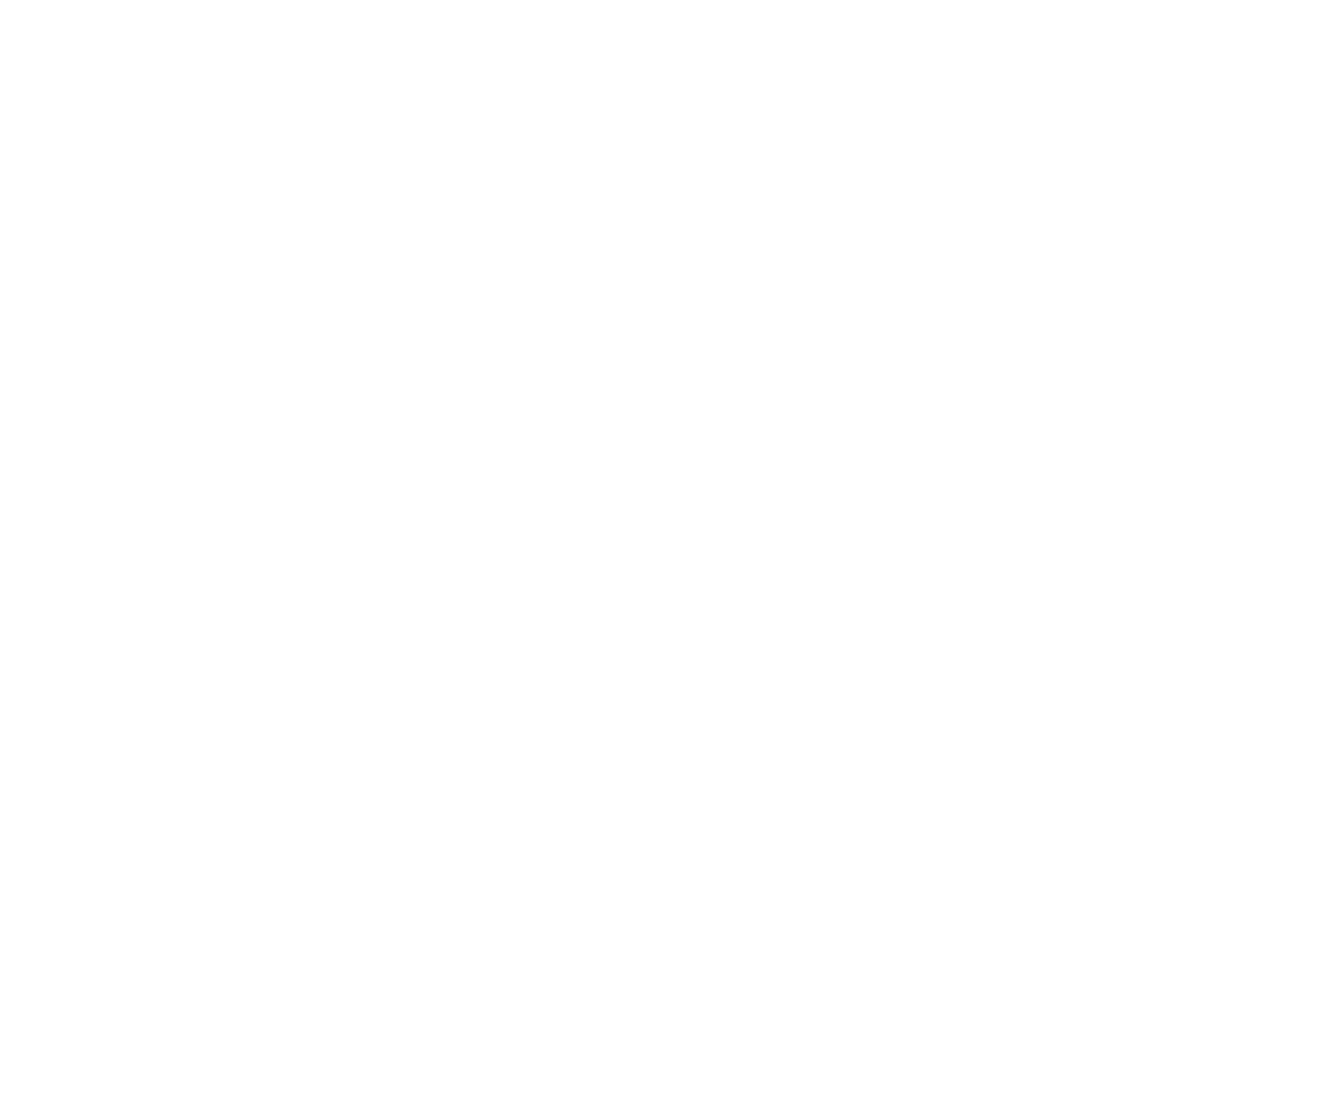

20200708-fly204011_07082020-204011: 2 crossovers, 3 reentries at max
20200708-fly204011_07082020-204011: 2 crossovers, 3 reentries at max


/var/folders/6z/bhycp6jj4pxg1qt6h_j36h880000gn/T/ipykernel_52710/1550300882.py:40: MatplotlibDeprecationWarning: The close_event function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use callbacks.process('close_event', CloseEvent(...)) instead.
  pl.close()


<IPython.core.display.Javascript object>


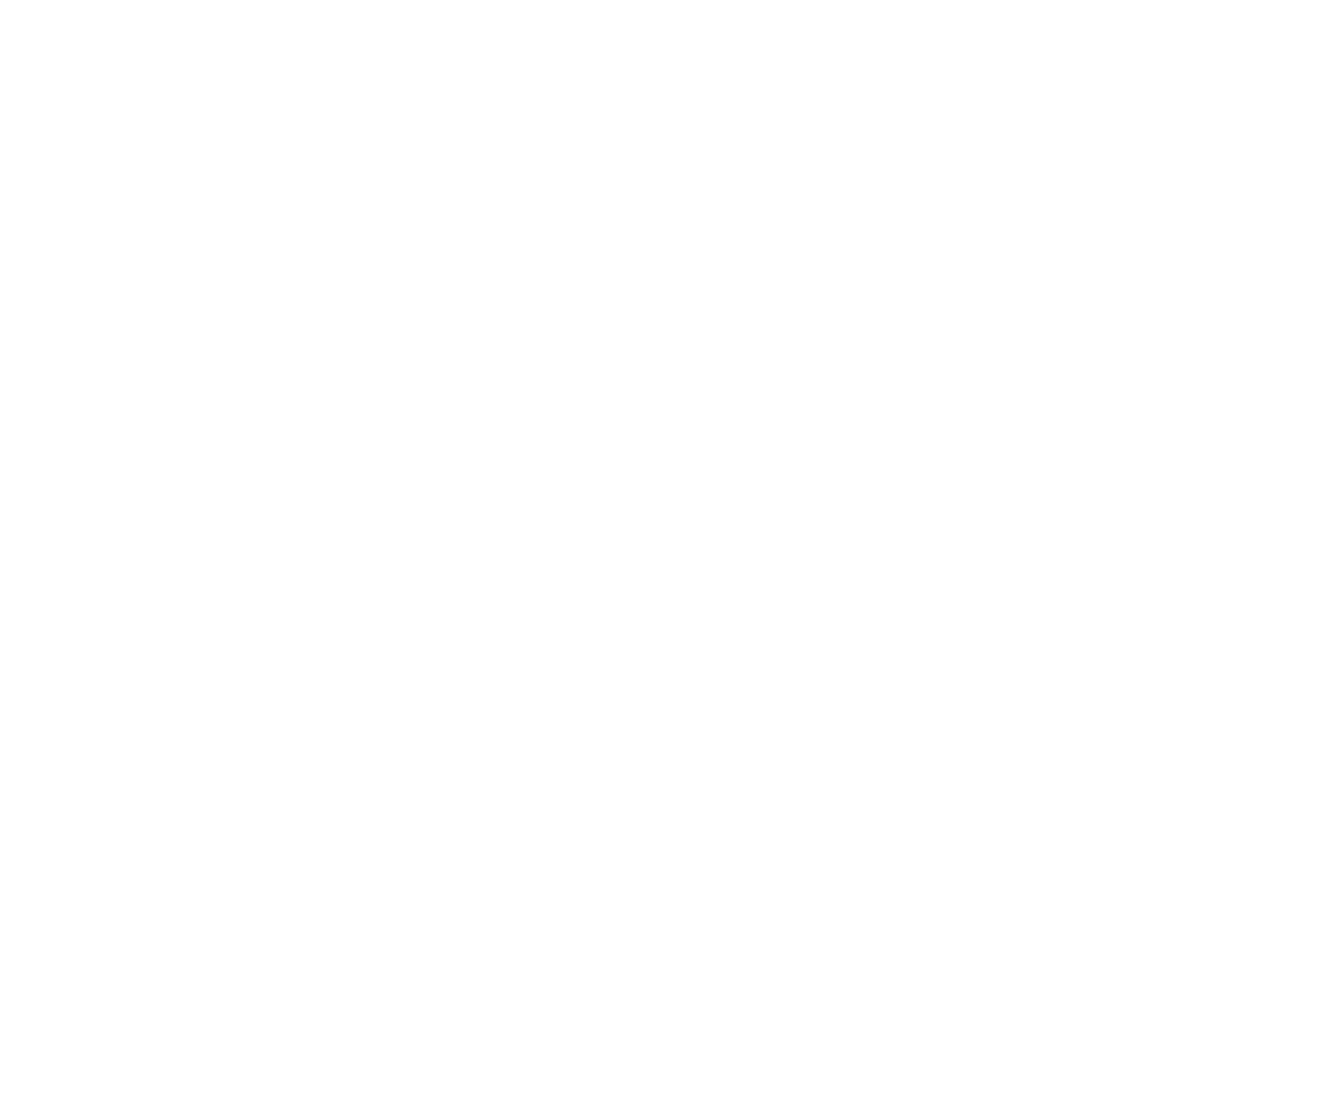

/var/folders/6z/bhycp6jj4pxg1qt6h_j36h880000gn/T/ipykernel_52710/1550300882.py:40: MatplotlibDeprecationWarning: The close_event function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use callbacks.process('close_event', CloseEvent(...)) instead.
  pl.close()


20200710-fly173701_07102020-173701: 0 crossovers, 6 reentries at max
20200710-fly173701_07102020-173701: 0 crossovers, 6 reentries at max


<IPython.core.display.Javascript object>


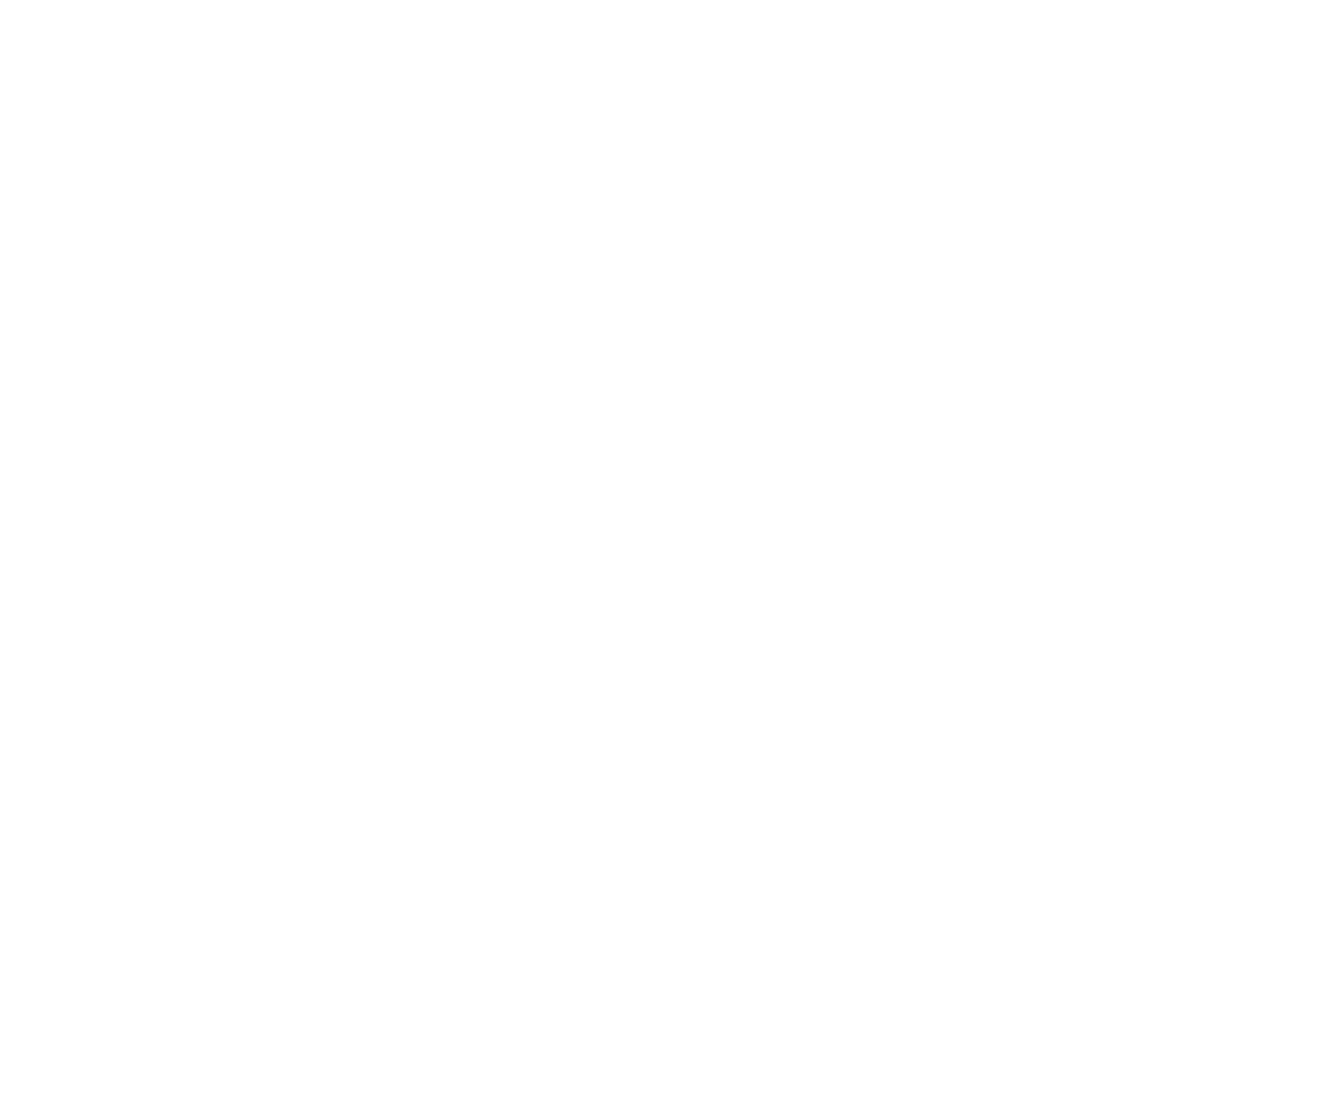

20200710-fly184213_07102020-184213: 1 crossovers, 4 reentries at max
20200710-fly184213_07102020-184213: 1 crossovers, 4 reentries at max


/var/folders/6z/bhycp6jj4pxg1qt6h_j36h880000gn/T/ipykernel_52710/1550300882.py:40: MatplotlibDeprecationWarning: The close_event function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use callbacks.process('close_event', CloseEvent(...)) instead.
  pl.close()


<IPython.core.display.Javascript object>


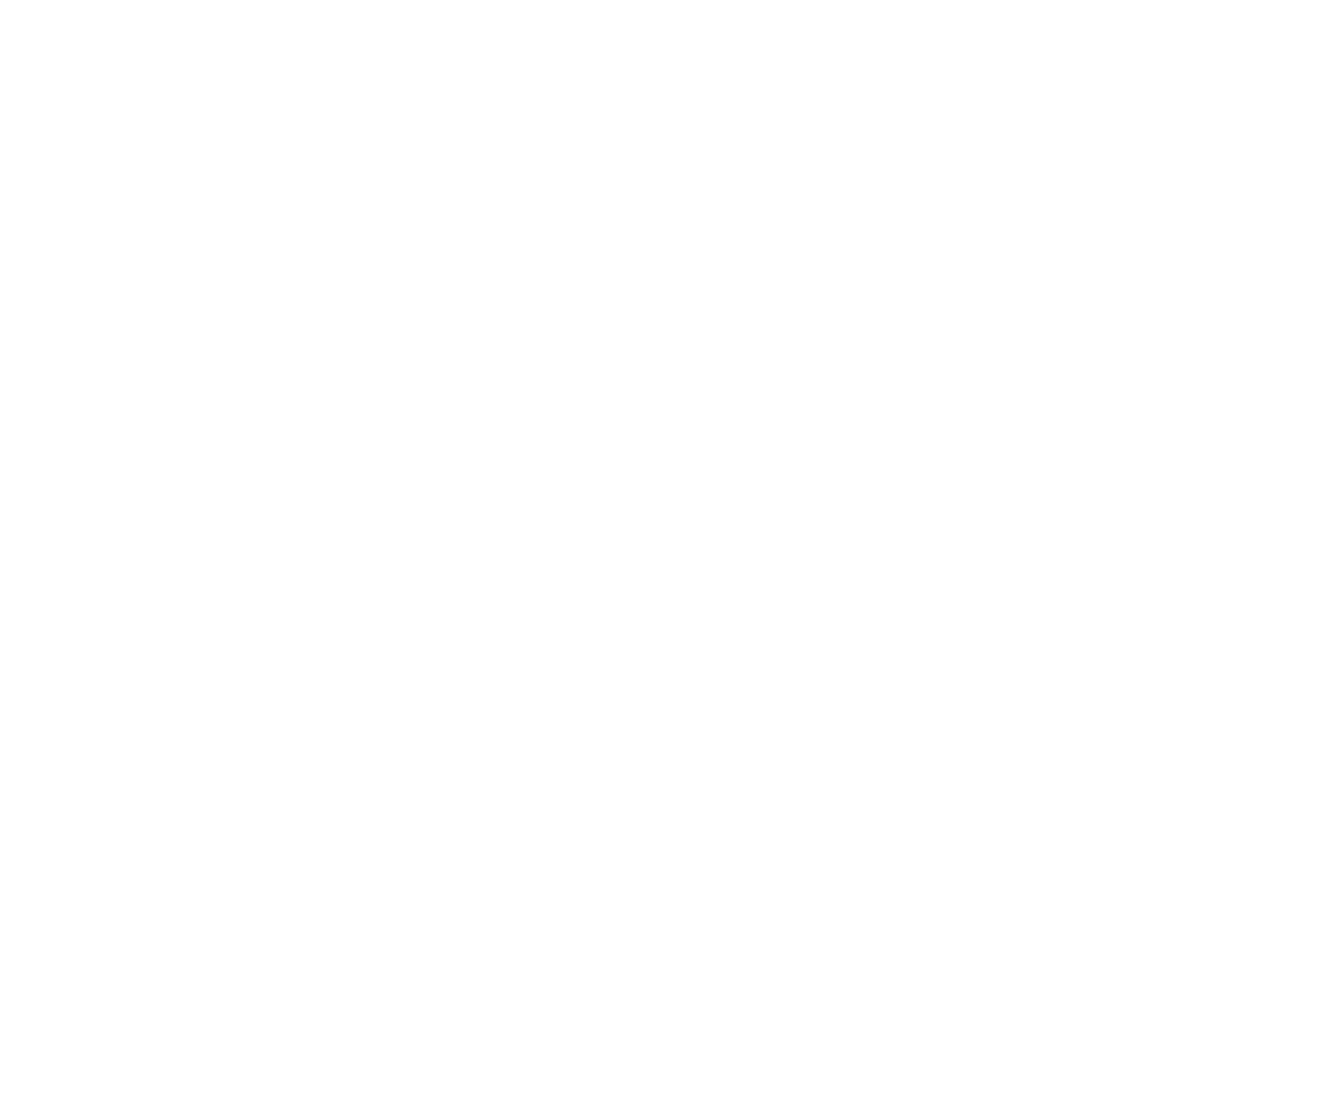

20200710-fly201510_07102020-201510: 0 crossovers, 36 reentries at max
20200710-fly201510_07102020-201510: 0 crossovers, 36 reentries at max


/var/folders/6z/bhycp6jj4pxg1qt6h_j36h880000gn/T/ipykernel_52710/1550300882.py:40: MatplotlibDeprecationWarning: The close_event function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use callbacks.process('close_event', CloseEvent(...)) instead.
  pl.close()


<IPython.core.display.Javascript object>


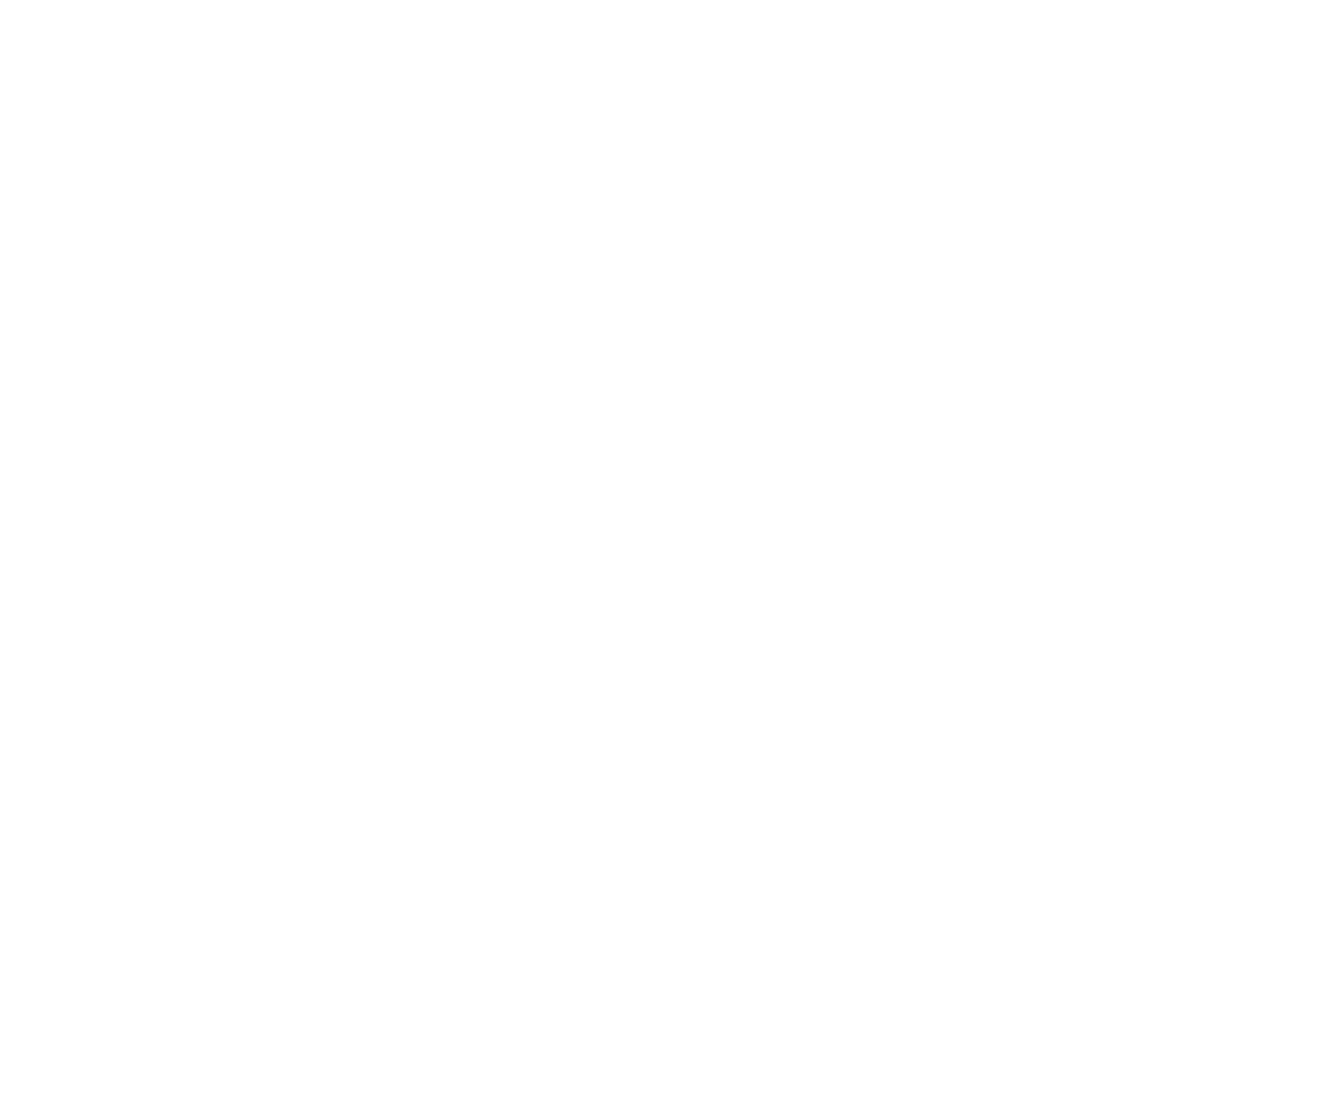

20200720-fly212128_07202020-212128: 3 crossovers, 7 reentries at max
20200720-fly212128_07202020-212128: 3 crossovers, 7 reentries at max


/var/folders/6z/bhycp6jj4pxg1qt6h_j36h880000gn/T/ipykernel_52710/1550300882.py:40: MatplotlibDeprecationWarning: The close_event function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use callbacks.process('close_event', CloseEvent(...)) instead.
  pl.close()


<IPython.core.display.Javascript object>


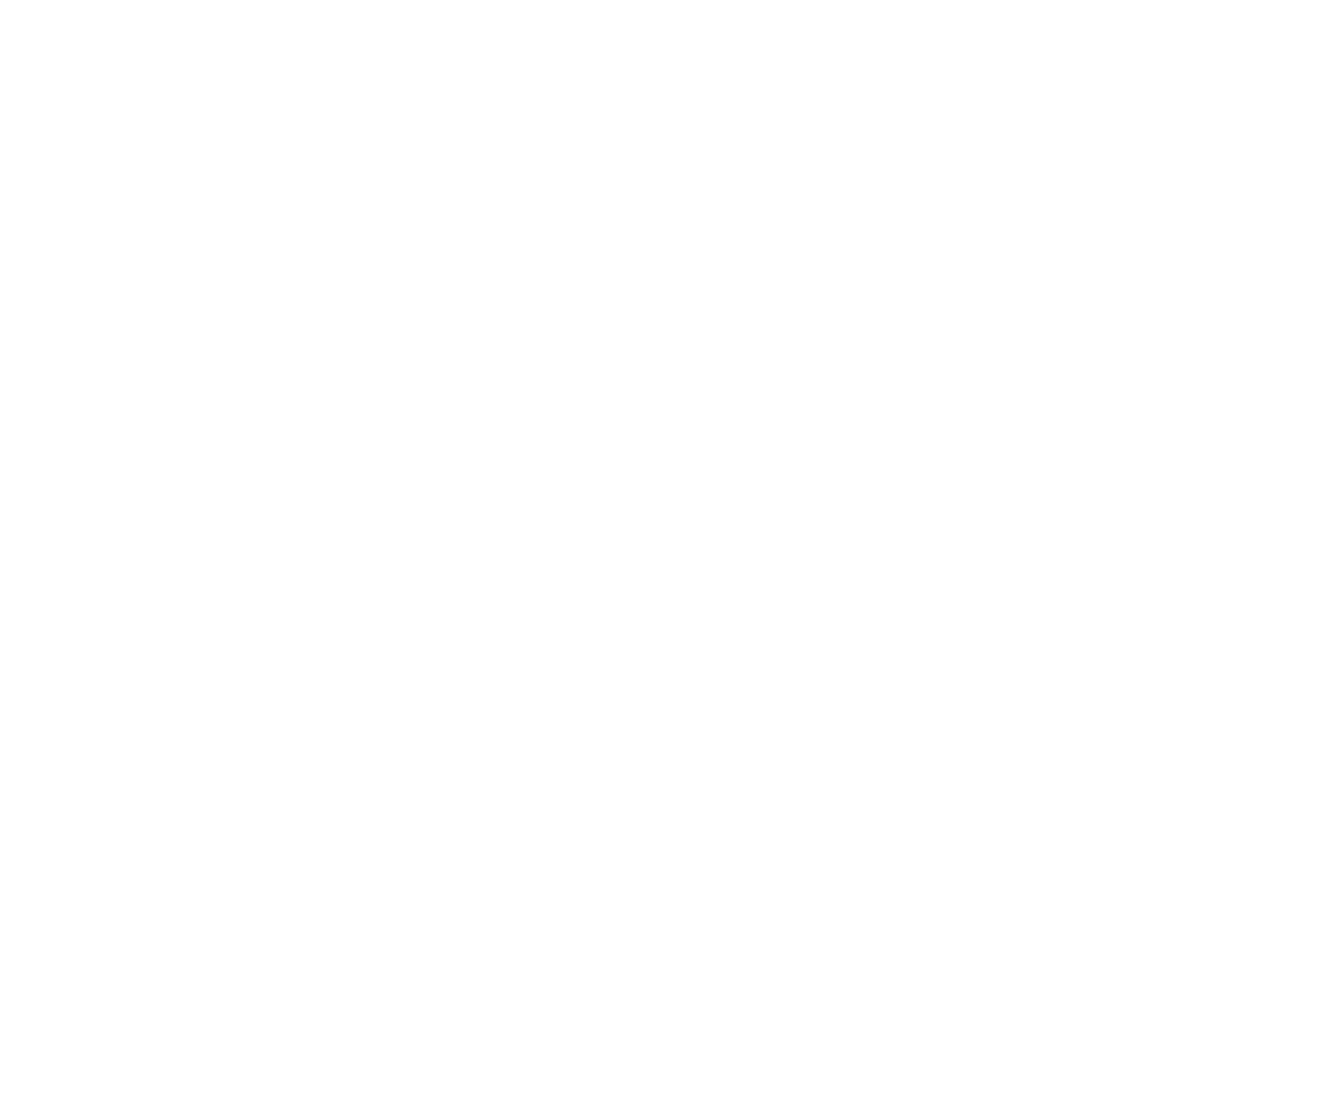

20200814-fly202143_08142020-202143: 1 crossovers, 4 reentries at max
20200814-fly202143_08142020-202143: 1 crossovers, 4 reentries at max


/var/folders/6z/bhycp6jj4pxg1qt6h_j36h880000gn/T/ipykernel_52710/1550300882.py:40: MatplotlibDeprecationWarning: The close_event function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use callbacks.process('close_event', CloseEvent(...)) instead.
  pl.close()


<IPython.core.display.Javascript object>


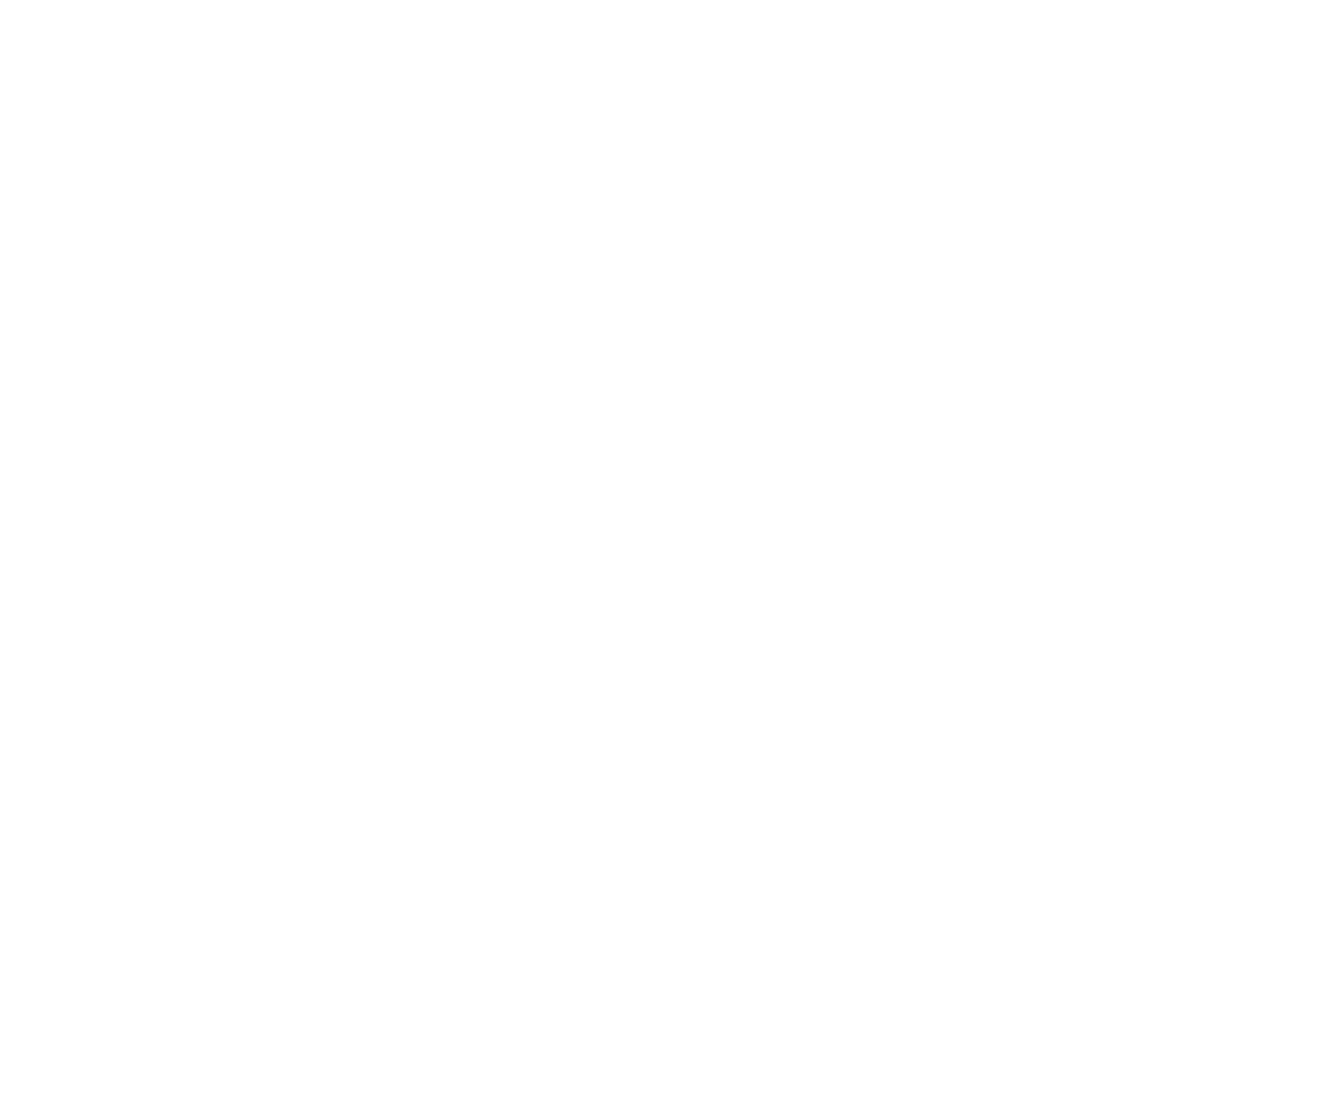

/var/folders/6z/bhycp6jj4pxg1qt6h_j36h880000gn/T/ipykernel_52710/1550300882.py:40: MatplotlibDeprecationWarning: The close_event function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use callbacks.process('close_event', CloseEvent(...)) instead.
  pl.close()


<IPython.core.display.Javascript object>


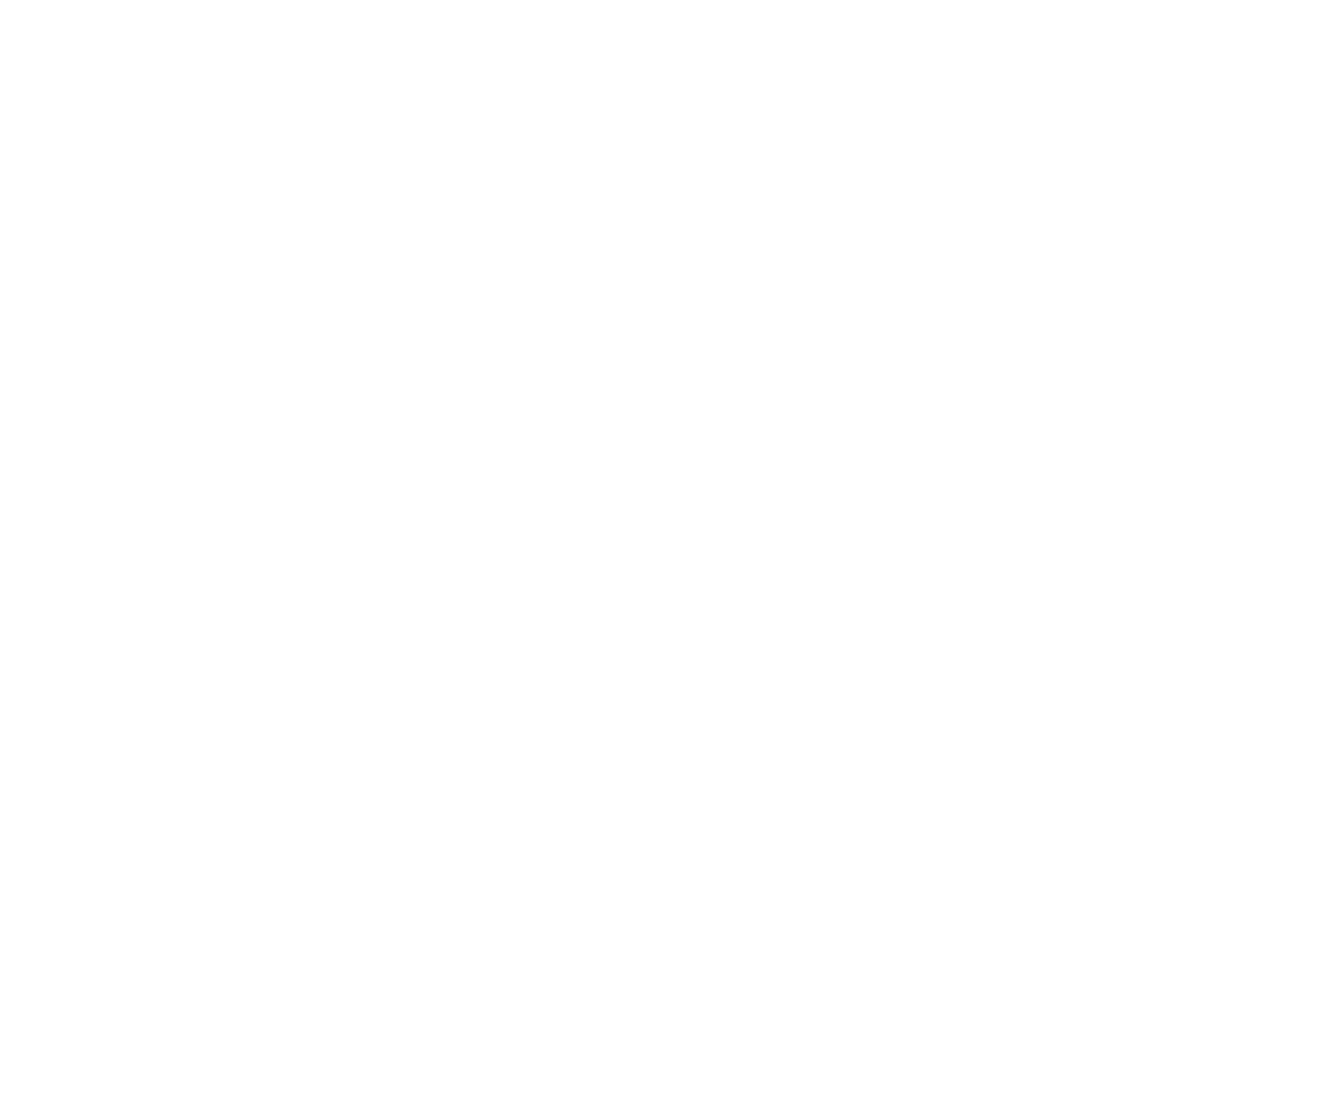

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


20200824-fly211008_08242020-211008: 1 crossovers, 6 reentries at max
20200824-fly211008_08242020-211008: 1 crossovers, 6 reentries at max


/var/folders/6z/bhycp6jj4pxg1qt6h_j36h880000gn/T/ipykernel_52710/1550300882.py:40: MatplotlibDeprecationWarning: The close_event function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use callbacks.process('close_event', CloseEvent(...)) instead.
  pl.close()


<IPython.core.display.Javascript object>


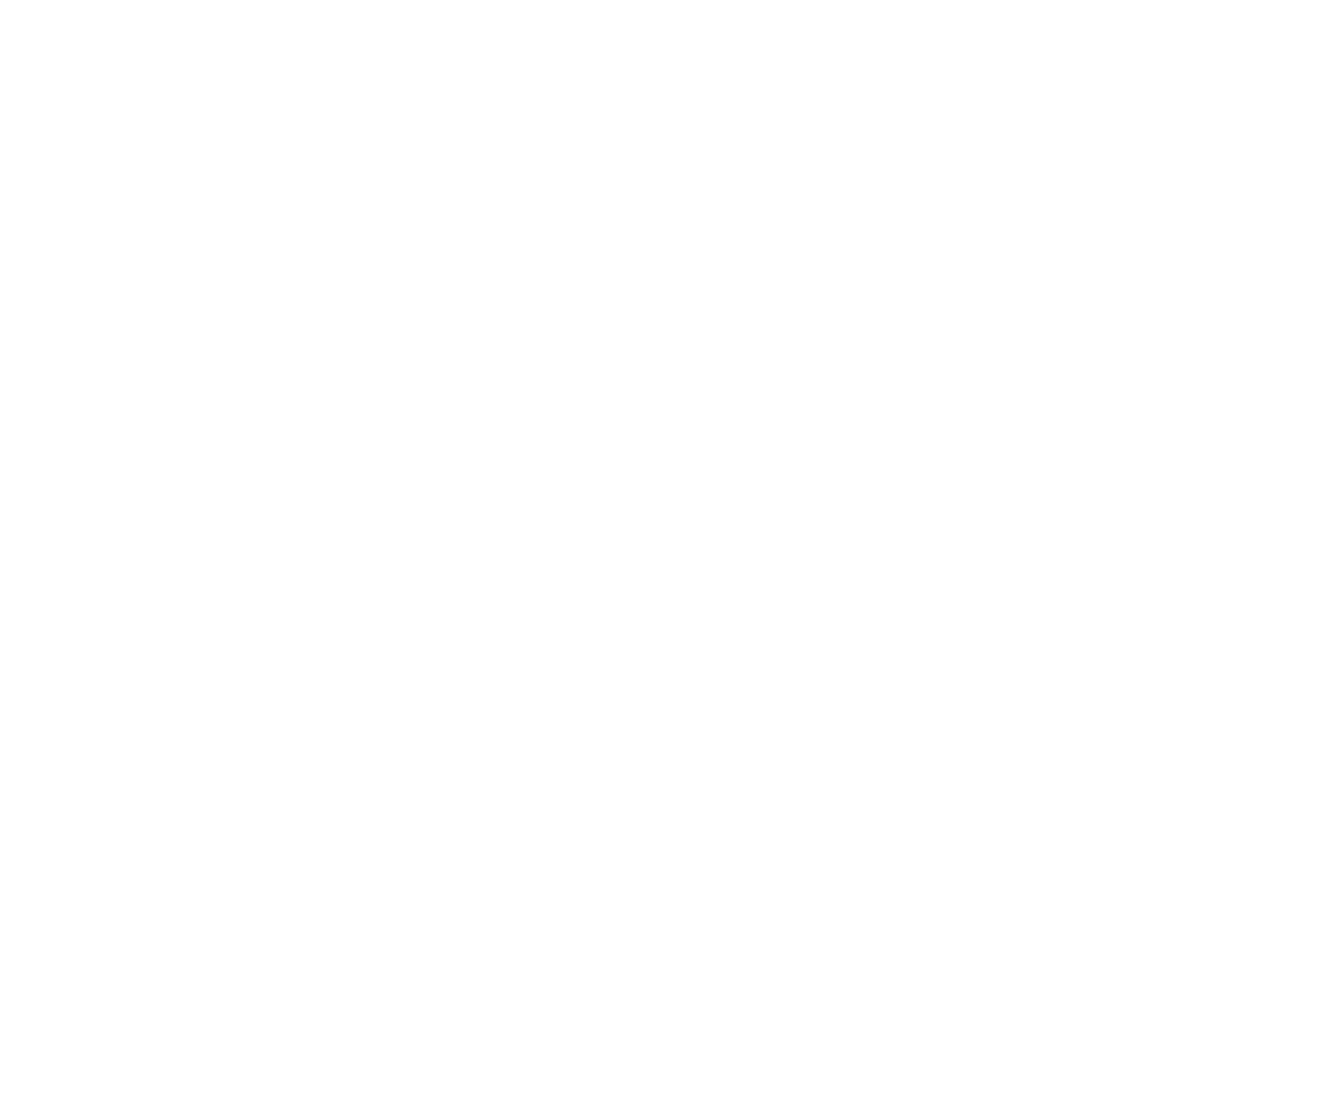

20200825-fly021424_08252020-021424: 0 crossovers, 14 reentries at max
20200825-fly021424_08252020-021424: 0 crossovers, 14 reentries at max


/var/folders/6z/bhycp6jj4pxg1qt6h_j36h880000gn/T/ipykernel_52710/1550300882.py:40: MatplotlibDeprecationWarning: The close_event function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use callbacks.process('close_event', CloseEvent(...)) instead.
  pl.close()


<IPython.core.display.Javascript object>


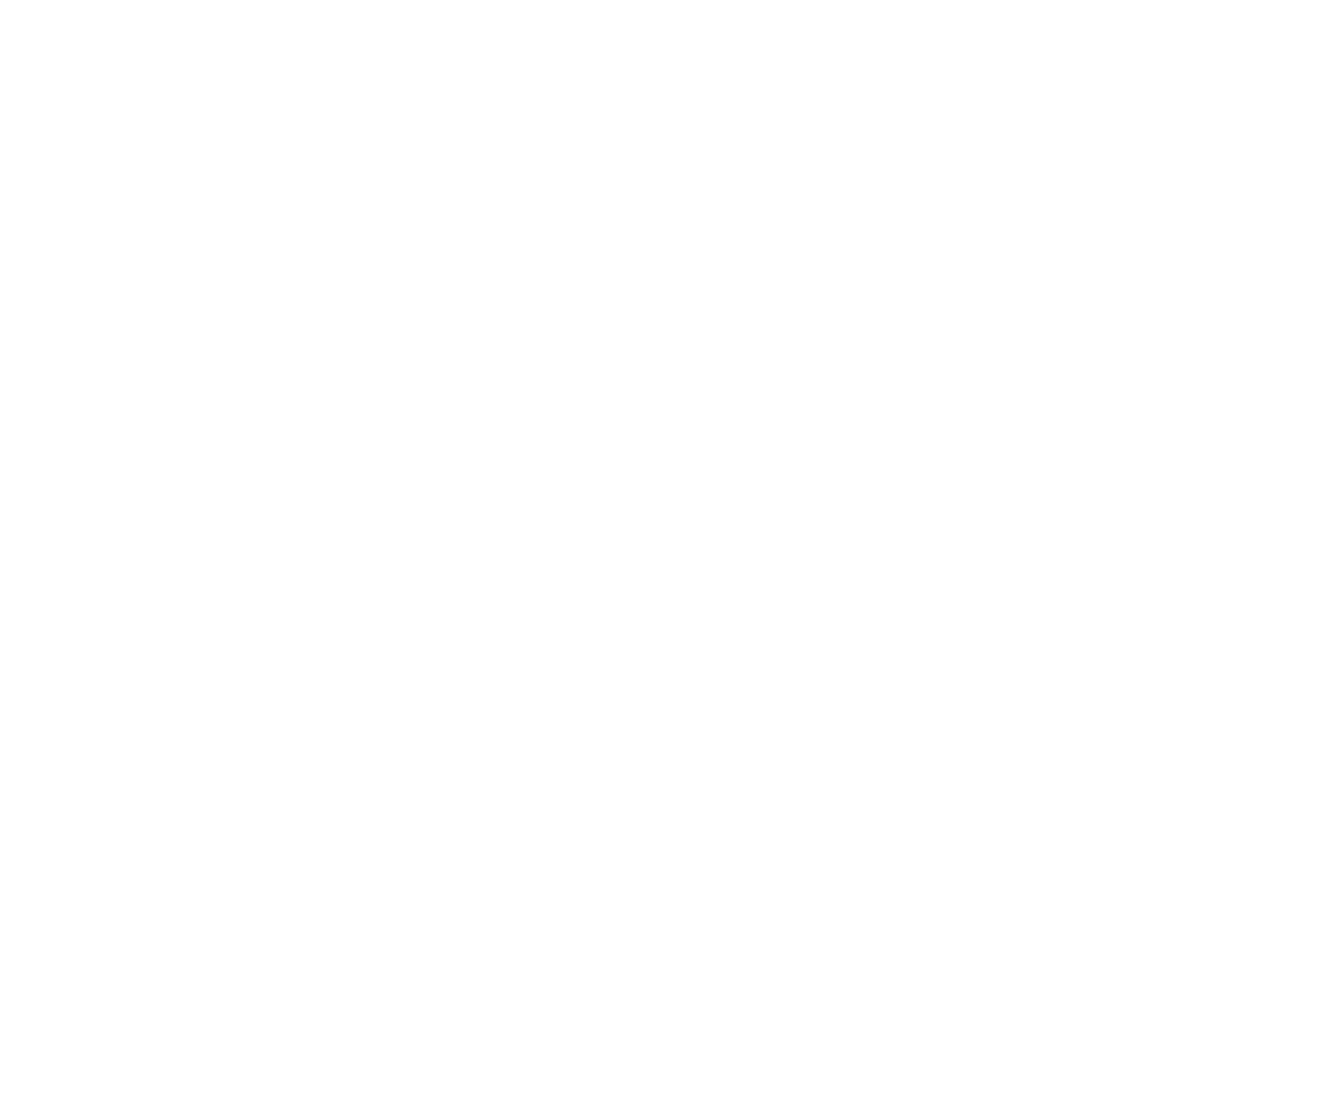

20200904-fly1_09042020-112635: 0 crossovers, 17 reentries at max
20200904-fly1_09042020-112635: 0 crossovers, 17 reentries at max


/var/folders/6z/bhycp6jj4pxg1qt6h_j36h880000gn/T/ipykernel_52710/1550300882.py:40: MatplotlibDeprecationWarning: The close_event function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use callbacks.process('close_event', CloseEvent(...)) instead.
  pl.close()


<IPython.core.display.Javascript object>


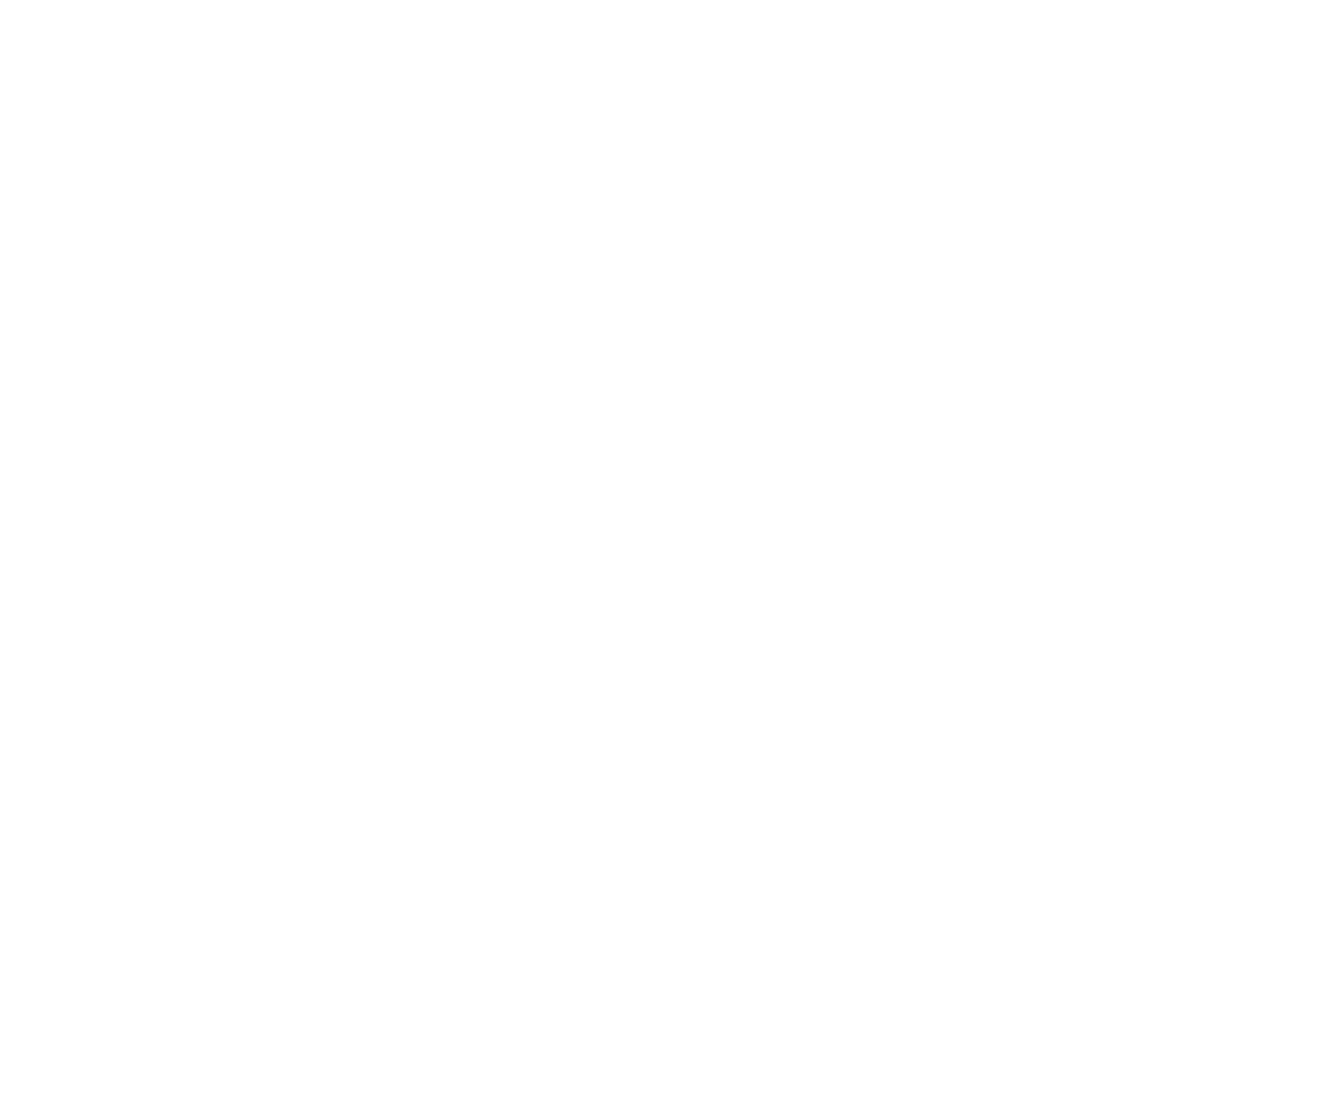

20200908-fly10_09082020-150114: 0 crossovers, 22 reentries at max
20200908-fly10_09082020-150114: 0 crossovers, 22 reentries at max


/var/folders/6z/bhycp6jj4pxg1qt6h_j36h880000gn/T/ipykernel_52710/1550300882.py:40: MatplotlibDeprecationWarning: The close_event function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use callbacks.process('close_event', CloseEvent(...)) instead.
  pl.close()


<IPython.core.display.Javascript object>


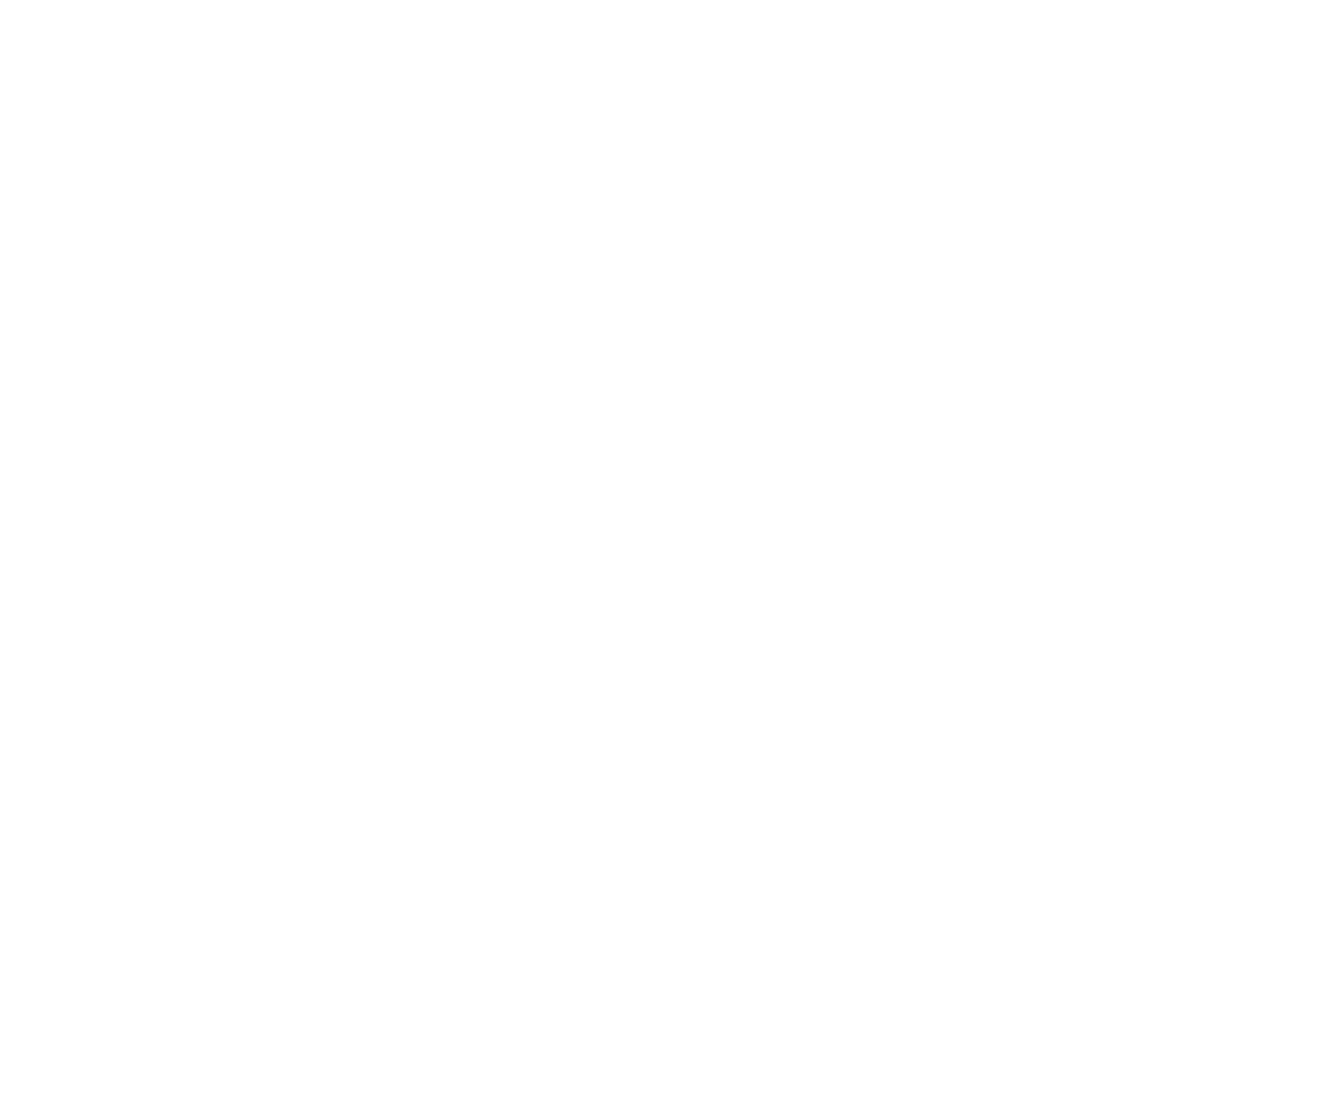

20200908-fly10_09082020-151637: 0 crossovers, 2 reentries at max
20200908-fly10_09082020-151637: 0 crossovers, 2 reentries at max


/var/folders/6z/bhycp6jj4pxg1qt6h_j36h880000gn/T/ipykernel_52710/1550300882.py:40: MatplotlibDeprecationWarning: The close_event function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use callbacks.process('close_event', CloseEvent(...)) instead.
  pl.close()


<IPython.core.display.Javascript object>


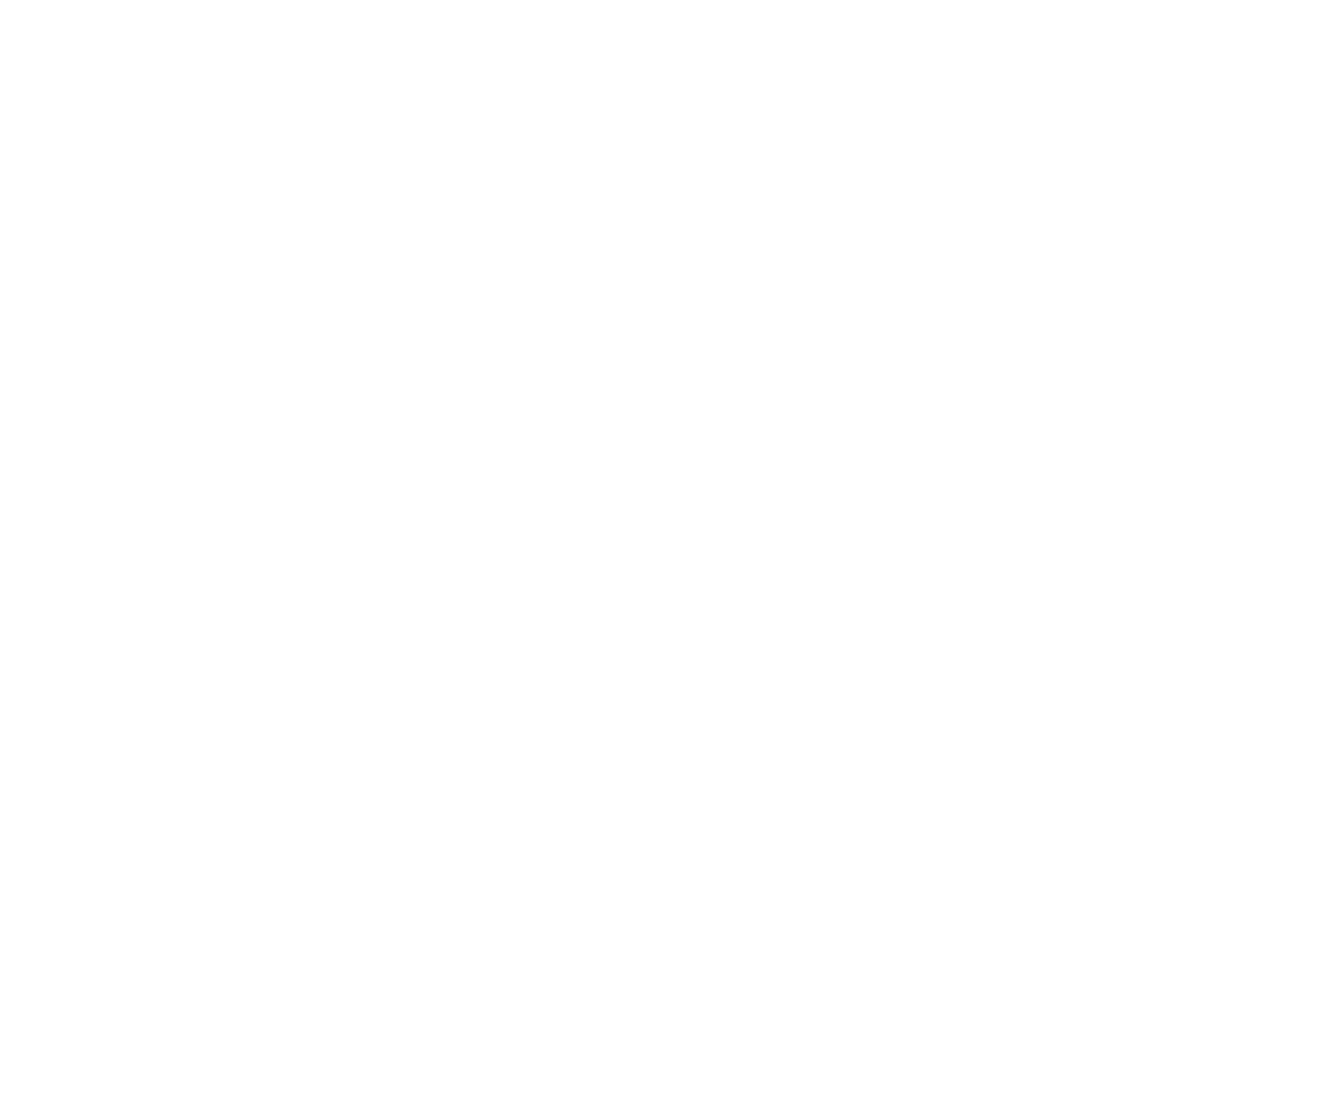

/var/folders/6z/bhycp6jj4pxg1qt6h_j36h880000gn/T/ipykernel_52710/1550300882.py:40: MatplotlibDeprecationWarning: The close_event function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use callbacks.process('close_event', CloseEvent(...)) instead.
  pl.close()


<IPython.core.display.Javascript object>


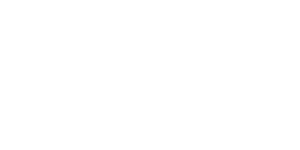

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


20200908-fly9_09082020-132608: 0 crossovers, 22 reentries at max
20200908-fly9_09082020-132608: 0 crossovers, 22 reentries at max


/var/folders/6z/bhycp6jj4pxg1qt6h_j36h880000gn/T/ipykernel_52710/1550300882.py:40: MatplotlibDeprecationWarning: The close_event function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use callbacks.process('close_event', CloseEvent(...)) instead.
  pl.close()


<IPython.core.display.Javascript object>


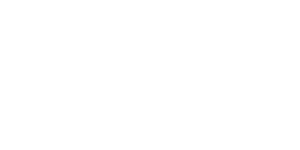

20200908-fly9_09082020-134131: 0 crossovers, 28 reentries at max
20200908-fly9_09082020-134131: 0 crossovers, 28 reentries at max


/var/folders/6z/bhycp6jj4pxg1qt6h_j36h880000gn/T/ipykernel_52710/1550300882.py:40: MatplotlibDeprecationWarning: The close_event function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use callbacks.process('close_event', CloseEvent(...)) instead.
  pl.close()


<IPython.core.display.Javascript object>


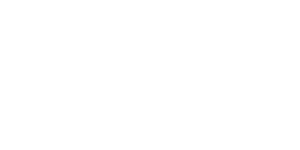

20200909-fly11_09092020-134020: 0 crossovers, 14 reentries at max
20200909-fly11_09092020-134020: 0 crossovers, 14 reentries at max


/var/folders/6z/bhycp6jj4pxg1qt6h_j36h880000gn/T/ipykernel_52710/1550300882.py:40: MatplotlibDeprecationWarning: The close_event function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use callbacks.process('close_event', CloseEvent(...)) instead.
  pl.close()


<IPython.core.display.Javascript object>


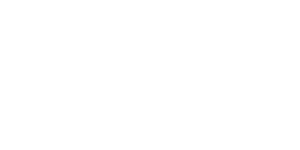

20200909-fly11_09092020-135251: 0 crossovers, 4 reentries at max
20200909-fly11_09092020-135251: 0 crossovers, 4 reentries at max


/var/folders/6z/bhycp6jj4pxg1qt6h_j36h880000gn/T/ipykernel_52710/1550300882.py:40: MatplotlibDeprecationWarning: The close_event function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use callbacks.process('close_event', CloseEvent(...)) instead.
  pl.close()


<IPython.core.display.Javascript object>


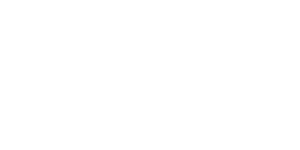

20200909-fly12_09092020-140902: 0 crossovers, 4 reentries at max
20200909-fly12_09092020-140902: 0 crossovers, 4 reentries at max


/var/folders/6z/bhycp6jj4pxg1qt6h_j36h880000gn/T/ipykernel_52710/1550300882.py:40: MatplotlibDeprecationWarning: The close_event function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use callbacks.process('close_event', CloseEvent(...)) instead.
  pl.close()


<IPython.core.display.Javascript object>


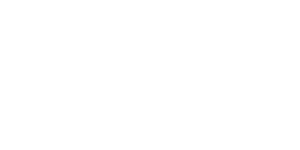

/var/folders/6z/bhycp6jj4pxg1qt6h_j36h880000gn/T/ipykernel_52710/1550300882.py:40: MatplotlibDeprecationWarning: The close_event function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use callbacks.process('close_event', CloseEvent(...)) instead.
  pl.close()


20220530-fly0_05302022-190526: 2 crossovers, 60 reentries at max
20220530-fly0_05302022-190526: 2 crossovers, 60 reentries at max


<IPython.core.display.Javascript object>


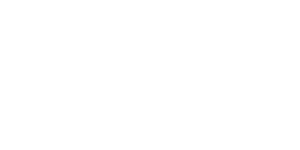

20220602-fly1_06022022-133201: 1 crossovers, 6 reentries at max
20220602-fly1_06022022-133201: 1 crossovers, 6 reentries at max


/var/folders/6z/bhycp6jj4pxg1qt6h_j36h880000gn/T/ipykernel_52710/1550300882.py:40: MatplotlibDeprecationWarning: The close_event function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use callbacks.process('close_event', CloseEvent(...)) instead.
  pl.close()


<IPython.core.display.Javascript object>


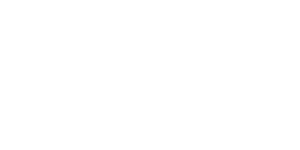

20220602-fly2_06022022-143134: 0 crossovers, 15 reentries at max
20220602-fly2_06022022-143134: 0 crossovers, 15 reentries at max


/var/folders/6z/bhycp6jj4pxg1qt6h_j36h880000gn/T/ipykernel_52710/1550300882.py:40: MatplotlibDeprecationWarning: The close_event function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use callbacks.process('close_event', CloseEvent(...)) instead.
  pl.close()


<IPython.core.display.Javascript object>


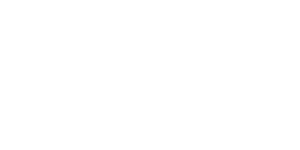

20220602-fly3_06022022-163857: 0 crossovers, 9 reentries at max
20220602-fly3_06022022-163857: 0 crossovers, 9 reentries at max


/var/folders/6z/bhycp6jj4pxg1qt6h_j36h880000gn/T/ipykernel_52710/1550300882.py:40: MatplotlibDeprecationWarning: The close_event function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use callbacks.process('close_event', CloseEvent(...)) instead.
  pl.close()


<IPython.core.display.Javascript object>


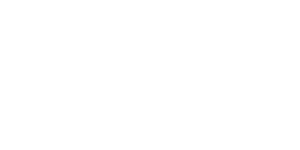

20220602-fly4_06022022-181747: 1 crossovers, 9 reentries at max
20220602-fly4_06022022-181747: 1 crossovers, 9 reentries at max


/var/folders/6z/bhycp6jj4pxg1qt6h_j36h880000gn/T/ipykernel_52710/1550300882.py:40: MatplotlibDeprecationWarning: The close_event function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use callbacks.process('close_event', CloseEvent(...)) instead.
  pl.close()


<IPython.core.display.Javascript object>


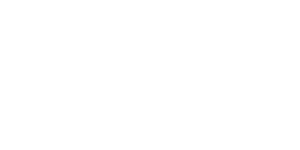

20220602-fly5_06022022-190523: 0 crossovers, 13 reentries at max
20220602-fly5_06022022-190523: 0 crossovers, 13 reentries at max


/var/folders/6z/bhycp6jj4pxg1qt6h_j36h880000gn/T/ipykernel_52710/1550300882.py:40: MatplotlibDeprecationWarning: The close_event function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use callbacks.process('close_event', CloseEvent(...)) instead.
  pl.close()


<IPython.core.display.Javascript object>


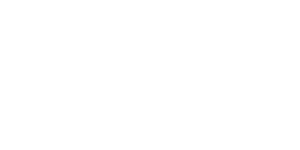

/var/folders/6z/bhycp6jj4pxg1qt6h_j36h880000gn/T/ipykernel_52710/1550300882.py:40: MatplotlibDeprecationWarning: The close_event function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use callbacks.process('close_event', CloseEvent(...)) instead.
  pl.close()


20220609-fly1_06092022-155055: 0 crossovers, 78 reentries at max
20220609-fly1_06092022-155055: 0 crossovers, 78 reentries at max


<IPython.core.display.Javascript object>


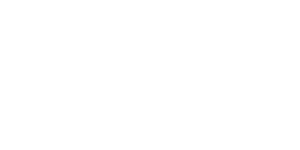

/var/folders/6z/bhycp6jj4pxg1qt6h_j36h880000gn/T/ipykernel_52710/1550300882.py:40: MatplotlibDeprecationWarning: The close_event function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use callbacks.process('close_event', CloseEvent(...)) instead.
  pl.close()


20220609-fly2_06092022-161935: 0 crossovers, 30 reentries at max
20220609-fly2_06092022-161935: 0 crossovers, 30 reentries at max


<IPython.core.display.Javascript object>


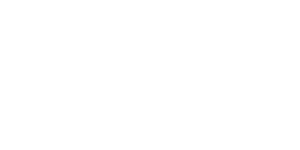

/var/folders/6z/bhycp6jj4pxg1qt6h_j36h880000gn/T/ipykernel_52710/1550300882.py:40: MatplotlibDeprecationWarning: The close_event function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use callbacks.process('close_event', CloseEvent(...)) instead.
  pl.close()


20220609-fly3_06092022-171500: 0 crossovers, 56 reentries at max
20220609-fly3_06092022-171500: 0 crossovers, 56 reentries at max


<IPython.core.display.Javascript object>


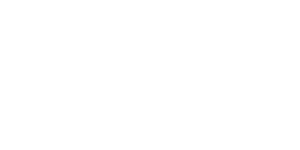

20220609-fly4_06092022-183500: 0 crossovers, 1 reentries at max
20220609-fly4_06092022-183500: 0 crossovers, 1 reentries at max


/var/folders/6z/bhycp6jj4pxg1qt6h_j36h880000gn/T/ipykernel_52710/1550300882.py:40: MatplotlibDeprecationWarning: The close_event function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use callbacks.process('close_event', CloseEvent(...)) instead.
  pl.close()


<IPython.core.display.Javascript object>


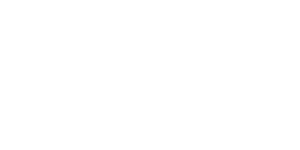

20220613-fly5_06132022-115953: 0 crossovers, 11 reentries at max
20220613-fly5_06132022-115953: 0 crossovers, 11 reentries at max


/var/folders/6z/bhycp6jj4pxg1qt6h_j36h880000gn/T/ipykernel_52710/1550300882.py:40: MatplotlibDeprecationWarning: The close_event function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use callbacks.process('close_event', CloseEvent(...)) instead.
  pl.close()


<IPython.core.display.Javascript object>


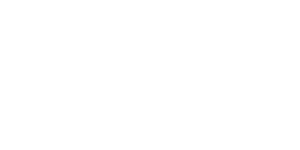

20220613-fly6_06132022-123909: 4 crossovers, 3 reentries at max
20220613-fly6_06132022-123909: 4 crossovers, 3 reentries at max


/var/folders/6z/bhycp6jj4pxg1qt6h_j36h880000gn/T/ipykernel_52710/1550300882.py:40: MatplotlibDeprecationWarning: The close_event function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use callbacks.process('close_event', CloseEvent(...)) instead.
  pl.close()


<IPython.core.display.Javascript object>


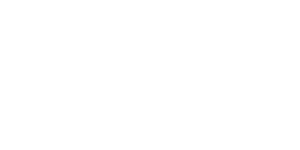

20220613-fly7_06132022-131030: 2 crossovers, 9 reentries at max
20220613-fly7_06132022-131030: 2 crossovers, 9 reentries at max


/var/folders/6z/bhycp6jj4pxg1qt6h_j36h880000gn/T/ipykernel_52710/1550300882.py:40: MatplotlibDeprecationWarning: The close_event function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use callbacks.process('close_event', CloseEvent(...)) instead.
  pl.close()


<IPython.core.display.Javascript object>


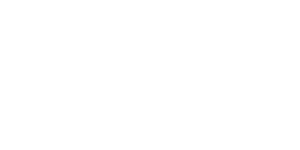

20220613-fly8_06132022-153709: 0 crossovers, 10 reentries at max
20220613-fly8_06132022-153709: 0 crossovers, 10 reentries at max


/var/folders/6z/bhycp6jj4pxg1qt6h_j36h880000gn/T/ipykernel_52710/1550300882.py:40: MatplotlibDeprecationWarning: The close_event function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use callbacks.process('close_event', CloseEvent(...)) instead.
  pl.close()


<IPython.core.display.Javascript object>


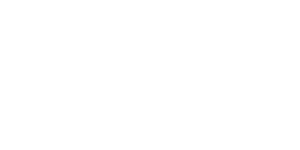

20220613-fly9_06132022-164625: 2 crossovers, 10 reentries at max
20220613-fly9_06132022-164625: 2 crossovers, 10 reentries at max


/var/folders/6z/bhycp6jj4pxg1qt6h_j36h880000gn/T/ipykernel_52710/1550300882.py:40: MatplotlibDeprecationWarning: The close_event function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use callbacks.process('close_event', CloseEvent(...)) instead.
  pl.close()


<IPython.core.display.Javascript object>


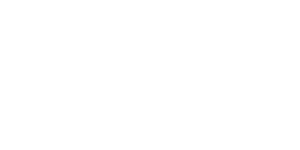

/var/folders/6z/bhycp6jj4pxg1qt6h_j36h880000gn/T/ipykernel_52710/1550300882.py:40: MatplotlibDeprecationWarning: The close_event function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use callbacks.process('close_event', CloseEvent(...)) instead.
  pl.close()


In [592]:
# trial_id =  '20200708-fly204011_07082020-204011'
# trial_id = '20200708-fly194358_07082020-194358'
# df_ = df0[df0['trial_id']==trial_id].copy()
dlist=[]
for trial_id, df_ in df0.groupby('trial_id'):
    # calculate entries and runs
    rundf, entry_df = get_longest_run(df_)
    n_crssovers=0; most_reentries=0;
    if entry_df is not None:
        n_crossovers, most_reentries = get_n_crossovers_and_entries(entry_df)
    # plot
    fig, axn = pl.subplots(1,3, sharex=True, sharey=True, figsize=(6,5))
    # traj
    ax = butil.plot_trajectory(df_, ax=axn[0], markersize=1, alpha=0.5)
    ax.set_title("N={} crossovers".format(n_crossovers), fontsize=7)
    # boutnum
    ax=axn[1]
    ax = butil.plot_trajectory(df_, ax=ax, hue_varname='boutnum', palette='colorblind',
                               markersize=1, alpha=0.5)
    ax.set_title('bouts', fontsize=7)
    # longest run
    ax=axn[2]
    sns.scatterplot(x='ft_posx', y='ft_posy', color='gray', data=df_, ax=ax, 
                    edgecolor='none', s=0.5)
    if rundf is not None:
        butil.plot_trajectory(rundf, ax=ax, center=True, plot_odor_onset=False, 
                          markersize=1, alpha=0.5)
    ax.set_title('longest run (n={} entries)'.format(most_reentries), fontsize=7)
    strip_borders = butil.find_strip_borders(df_)
    for ax in axn.flat:
        #ax.set_box_aspect(2)
        ax.legend(bbox_to_anchor=(0, -0.2), loc='upper left', ncols=3, fontsize=6)
        for (strip_min, strip_max) in strip_borders:
            butil.plot_odor_corridor(ax, strip_min, strip_max)
    pl.subplots_adjust(wspace=0.5, left=0.12, right=0.95, bottom=0.3, top=0.8)
    util.label_figure(fig, fig_id)
    fig.text(0.01, 0.9, trial_id)
    figname = 'longest_run_{}'.format(trial_id)
    pl.savefig(os.path.join(figdir, 'individuals', '{}.png'.format(figname)))
    pl.close()
    dlist.append(rundf)

In [24]:
trial_id = '20200630-fly184740_06302020-184740'
df_ = df0[df0['trial_id']==trial_id].copy()
strip_borders = butil.find_strip_borders(df_)

In [25]:
entered_left, entry_df = butil.check_entry_left_edge(df_, entry_ix=None, 
                                                     only_upwind_outbouts=False, return_bool=True)
# count N crossovers and max run length
max_entries = entry_df.groupby('consecutive_bout')['consecutive_count'].max()
max_entries

consecutive_bout
1    13
2     0
3    46
Name: consecutive_count, dtype: int64

In [26]:
n_crossovers, most_reentries = get_n_crossovers_and_entries(entry_df)
n_crossovers, most_reentries


20200630-fly184740_06302020-184740: 2 crossovers, 47 reentries at max


(2, 47)

In [27]:
max_entries = entry_df.groupby('consecutive_bout')['consecutive_count'].max()
n_crossovers = max_entries.shape[0]-1
most_reentries = max_entries.max()+1

In [28]:
entry_df[~entry_df['entry_left_edge']]

entry_index  previous_outbout  entry_left_edge  consecutive_bout  \
14        13337                30            False                 2   

    consecutive_count  
14                  0

<IPython.core.display.Javascript object>


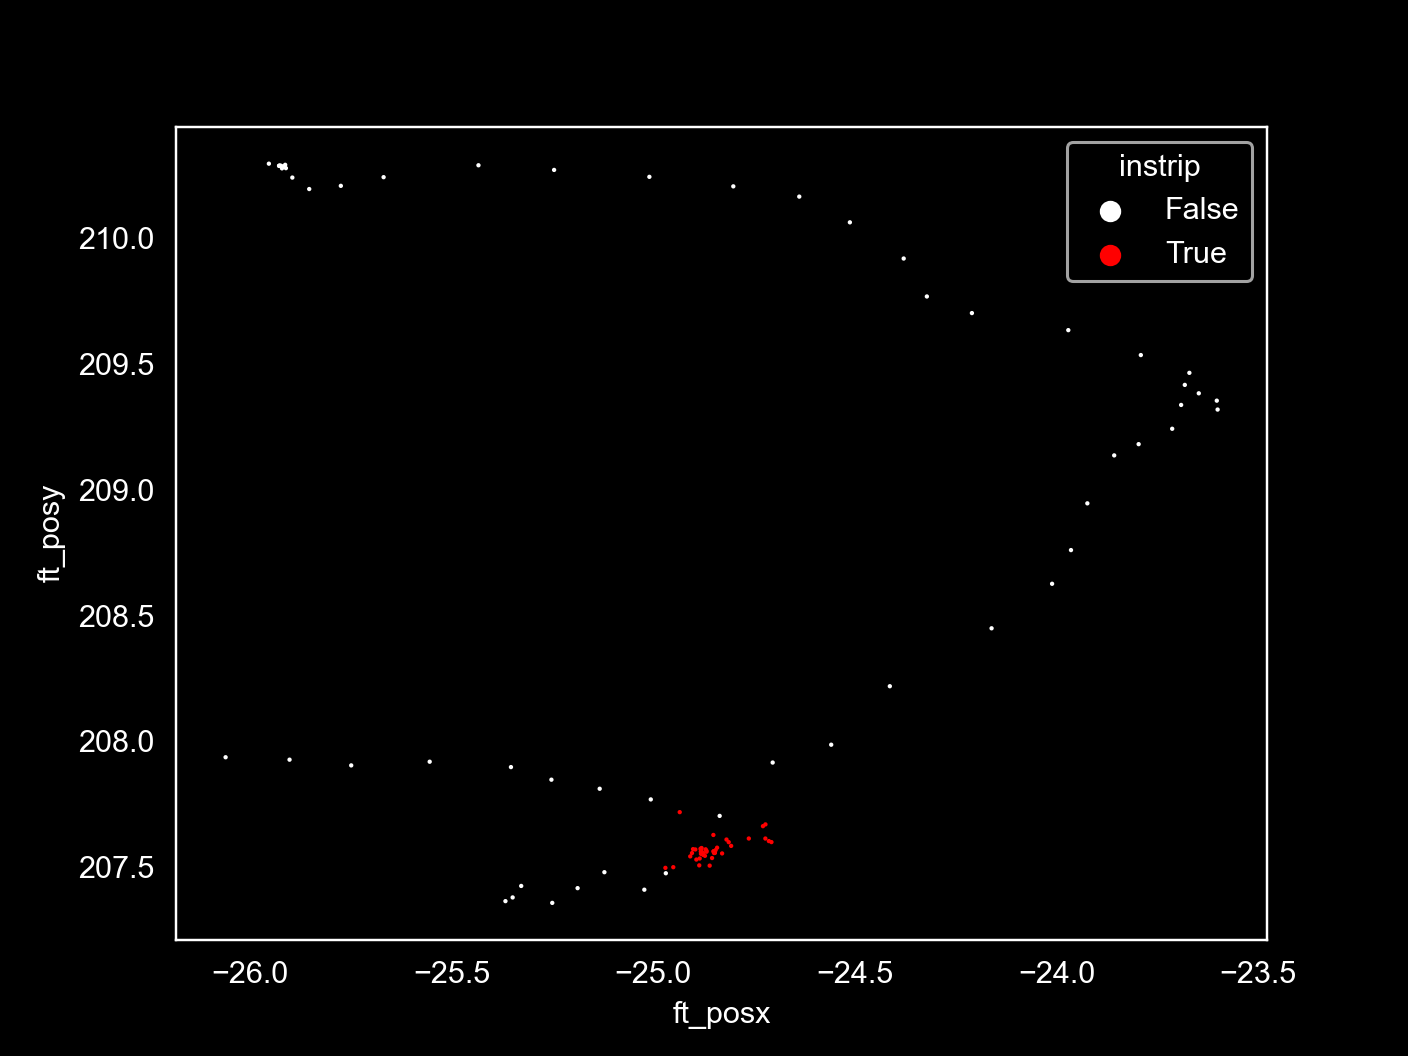

timestamp -- motor_step_command  mfc1_stpt  mfc2_stpt  mfc3_stpt  \
13137  06/30/2020-18:51:17.592908 -- 811965   0.765771        0.0   0.210205   
13138  06/30/2020-18:51:17.608529 -- 811953   0.765503        0.0   0.210473   
13139  06/30/2020-18:51:17.624150 -- 811945   0.765306        0.0   0.210670   
13140  06/30/2020-18:51:17.639772 -- 811938   0.765173        0.0   0.210803   
13141  06/30/2020-18:51:17.655393 -- 811938   0.765059        0.0   0.210917   
...                                     ...        ...        ...        ...   
13533  06/30/2020-18:51:24.138244 -- 811910   0.975976        0.0   0.000000   
13534  06/30/2020-18:51:24.153860 -- 811910   0.975976        0.0   0.000000   
13535  06/30/2020-18:51:24.169482 -- 811909   0.975976        0.0   0.000000   
13536  06/30/2020-18:51:24.185103 -- 811910   0.975976        0.0   0.000000   
13537  06/30/2020-18:51:24.200766 -- 811908   0.975976        0.0   0.000000   

       led1_stpt  led2_stpt  sig_status    ft_posx     ft_posy  ft_frame  ...  \
13137        0.0        0.0         NaN -24.448424  205.379541     13228  ...   
13138        1.0        0.0         NaN -24.309990  205.653432     13229  ...   
13139        1.0        0.0         NaN -24.283503  205.855509     13230  ...   
13140        1.0        0.0         NaN -24.133556  205.992288     13231  ...   
13141        1.0        0.0         NaN -24.126237  206.108787     13232  ...   
...          ...        ...         ...        ...         ...       ...  ...   
13533        0.0        0.0         NaN -25.474903  210.185694     13626  ...   
13534        0.0        0.0         NaN -25.477899  210.185754     13627  ...   
13535        0.0        0.0         NaN -25.468354  210.210348     13628  ...   
13536        0.0        0.0         NaN -25.476857  210.191656     13629  ...   
13537        0.0        0.0         NaN -25.509947  210.173668     13630  ...   

       genotype  boutnum      cum_time      speed  upwind_speed  \
13137   PAM>Chr       29  1.427570e+06  19.428256     16.485940   
13138   PAM>Chr       29  1.427788e+06  16.123441     15.234823   
13139   PAM>Chr       29  1.428005e+06  12.227998     10.845891   
13140   PAM>Chr       29  1.428222e+06   9.542390      8.106740   
13141   PAM>Chr       29  1.428440e+06   6.313207      5.763394   
...         ...      ...           ...        ...           ...   
13533   PAM>Chr       32  1.514936e+06   0.777053      0.148806   
13534   PAM>Chr       32  1.515160e+06   0.816608      0.789229   
13535   PAM>Chr       32  1.515384e+06   0.191847      0.188926   
13536   PAM>Chr       32  1.515607e+06   1.772700     -1.172499   
13537   PAM>Chr       32  1.515831e+06   1.525340     -1.169941   

       crosswind_speed euclid_dist upwind_dist crosswind_dist  bout_type  
13137        10.279636    0.302570    0.241165       0.182724    instrip  
13138         5.278780    0.306888    0.273891       0.138434    instrip  
13139         5.647175    0.203806    0.202078       0.026487    instrip  
13140         5.033685    0.202960    0.136779       0.149947    instrip  
13141         2.576796    0.116728    0.116499       0.007320    instrip  
...                ...         ...         ...            ...        ...  
13533        -0.762672    0.033468    0.006914       0.032746   outstrip  
13534         0.209679    0.002996    0.000059       0.002995   outstrip  
13535         0.033350    0.026382    0.024595       0.009545   outstrip  
13536        -1.329554    0.020535   -0.018692       0.008503   outstrip  
13537         0.978723    0.037664   -0.017988       0.033091   outstrip  

[401 rows x 42 columns]

In [29]:
entry_ix = 13337
fig, ax= pl.subplots()
sns.scatterplot(data=df_.loc[entry_ix-50:entry_ix+50], x='ft_posx', y='ft_posy', ax=ax, s=2,
                edgecolor='none', hue='instrip', palette={True:'r', False: 'w'})
df_.loc[entry_ix-200:entry_ix+200]

In [30]:
entry_df[entry_df['consecutive_bout']==2]
boutnums = [29, 30, 31, 32]

In [31]:
df_.loc[entry_ix-50:entry_ix+50]['boutnum'].unique()

array([30, 31, 32])

In [32]:
importlib.reload(butil)

<module 'behavior' from '/Users/julianarhee/Repositories/plume-tracking/behavior.py'>

In [33]:
fpath = [f for f in log_files if '06302020-184740' in f][0]
print(fpath)
testdf = butil.load_dataframe(fpath)

/Users/julianarhee/Library/CloudStorage/GoogleDrive-edge.tracking.ru@gmail.com/My Drive/Edge_Tracking/Analysis/0-degree/logs/06302020-184740_Odor.log


In [34]:
testdf = butil.parse_bouts(testdf)

In [35]:
boutdurs = butil.get_bout_durs(testdf, bout_varname='boutnum')
too_short = [k for k, v in boutdurs.items() if v < 0.5]

In [36]:
boutdurs

{1: 9.513381004333496,
 2: 89.26018500328064,
 3: 2.4056859016418457,
 4: 5.998586893081665,
 5: 0.7810790538787842,
 6: 17.152191877365112,
 7: 1.7652108669281006,
 8: 2.3900201320648193,
 9: 1.6871018409729004,
 10: 2.468168020248413,
 11: 1.7183449268341064,
 12: 16.652326822280884,
 13: 0.34366893768310547,
 14: 7.326400995254517,
 15: 2.1088778972625732,
 16: 3.280472993850708,
 17: 2.4369261264801025,
 18: 4.264613151550293,
 19: 0.10935091972351074,
 20: 0.24993610382080078,
 21: 0.5779762268066406,
 22: 5.264384031295776,
 23: 1.2184619903564453,
 24: 3.9678139686584473,
 25: 0.2655630111694336,
 26: 4.34271502494812,
 27: 0.12498188018798828,
 28: 0.8435509204864502,
 29: 4.264619827270508,
 30: 2.5618948936462402,
 31: 0.07811403274536133,
 32: 0.5155050754547119,
 33: 0.8435530662536621,
 34: 10.856822967529297,
 35: 0.9685609340667725,
 36: 0.9372830390930176,
 37: 1.843303918838501,
 38: 4.1552698612213135,
 39: 1.5777671337127686,
 40: 0.0,
 41: 0.0624849796295166,
 42: 2

In [37]:
# ax = butil.plot_trajectory(df_, center=True)
# ax = butil.plot_trajectory(df_[df_['boutnum'].isin([30, 31, 32])], center=True, ax=ax,
#                            hue_varname='boutnum', palette='colorblind', markersize=5)
# obounds = butil.find_strip_borders(df_)
# for (omin, omax) in obounds:
#     butil.plot_odor_corridor(ax, odor_xmin=omin, odor_xmax=omax)
d_ = df_[df_['boutnum'].isin(boutnums)]
t_ = testdf.loc[d_.index] #[testdf['boutnum'].isin(boutnums)]

fig, axn = pl.subplots(1,4, sharex=True, sharey=True, figsize=(8,5))
# traj
ax=axn[0]
ax = sns.scatterplot(x='ft_posx', y='ft_posy', hue='instrip', data=t_, ax=ax, 
                edgecolor='none', s=2, palette={True: 'r', False: 'w'})
ax.set_title("N={} crossovers".format(n_crossovers), fontsize=7)
ax=axn[1]
ax = sns.scatterplot(x='ft_posx', y='ft_posy', hue='boutnum', data=t_, ax=ax, 
                edgecolor='none', s=2, palette='colorblind')
ax.set_title("N={} crossovers".format(n_crossovers), fontsize=7)
                     
# boutnum
ax=axn[2]
ax = sns.scatterplot(x='ft_posx', y='ft_posy', hue='boutnum', data=d_, ax=ax, 
                edgecolor='none', s=2, palette='colorblind')
ax.set_title('bouts', fontsize=7)
# longest run
ax=axn[3]
sns.scatterplot(x='ft_posx', y='ft_posy', hue='time', data=d_, ax=ax, 
                edgecolor='none', s=5, palette='viridis')
ax.plot(d_['ft_posx'], d_['ft_posy'], lw=0.5, color='w')

for ax in axn:
    ax.legend(bbox_to_anchor=(0, -0.2), loc='upper left', fontsize=6, ncols=3)
# if rundf is not None:
#     butil.plot_trajectory(rundf, ax=ax, center=True, plot_odor_onset=False, 
#                       markersize=1, alpha=0.5)
pl.subplots_adjust(bottom=0.3)

<IPython.core.display.Javascript object>

In [ ]:
butil.get_bou

In [676]:
from matplotlib import animation
# mpl.use('Qt5Agg') #use Qt5 as backend, comment this line for default backend

In [732]:
(1/30.)*1000


33.333333333333336

In [868]:
class AnimatedScatter(object):
    """An animated scatter plot using matplotlib.animations.FuncAnimation."""
    def __init__(self, d_, hue_var='instrip', strip_borders=[], 
                 n_trailing=10, offset=5, interval=33.33): #, numpoints=50):
        self.numpoints = len(d_) #numpoints
        self.stream = self.data_stream(d_, hue_var=hue_var)
        self.strip_borders = strip_borders
        self.n_trailing = n_trailing
        # Setup the figure and axes...
        self.fig, self.ax = pl.subplots()
        self.scat0 = self.ax.scatter(d_['ft_posx'], d_['ft_posy'], c=d_['instrip'], 
                                     s=2, edgecolor='none', cmap='coolwarm')
        for (omin, omax) in self.strip_borders:
            self.ax.axvline(x=omin, color='w', lw=0.25, linestyle=':')
            self.ax.axvline(x=omax, color='w', lw=0.25, linestyle=':')
        xmin, xmax = np.floor(d_['ft_posx'].min()), np.ceil(d_['ft_posx'].max())
        ymin, ymax = np.floor(d_['ft_posy'].min()), np.ceil(d_['ft_posy'].max())
        self.ax.axis([xmin-offset, xmax+offset, ymin-offset*2, ymax+offset*2])
        print(xmin, xmax, ymin, ymax)
        # Then setup FuncAnimation.
        self.ani = animation.FuncAnimation(self.fig, self.update, interval=interval, 
                                          init_func=self.setup_plot, blit=True,
                                          save_count=d_.shape[0])

    def setup_plot(self, cmap='coolwarm', vmin=0, vmax=1):
        """Initial drawing of the scatter plot."""
        #x, y, c = next(self.stream).T
        x, y, c = self.stream.T
        # print(x, y, c)
        #self.scat = self.ax.scatter([], [], c=[], s=5, vmin=vmin, vmax=vmax,
        #                            cmap=cmap, edgecolor='none')
        self.scat = self.ax.scatter([], [], c=[], s=5, vmin=vmin, vmax=vmax,
                                    edgecolor='none')
        # For FuncAnimation's sake, we need to return the artist we'll be using
        # Note that it expects a sequence of artists, thus the trailing comma.
        return self.scat,

    def data_stream(self, d_, hue_var='instrip'):
        """Generate a random walk (brownian motion). Data is scaled to produce
        a soft "flickering" effect."""
        #xy = (np.random.random((self.numpoints, 2))-0.5)*10
        #s, c = np.random.random((self.numpoints, 2)).T
        x = d_['ft_posx'].values
        y = d_['ft_posy'].values
        c = d_[hue_var].values
        #while True:
            #xy += 0.03 * (np.random.random((self.numpoints, 2)) - 0.5)
            #s += 0.05 * (np.random.random(self.numpoints) - 0.5)
            #c += 0.02 * (np.random.random(self.numpoints) - 0.5)
            #yield np.c_[x, y, c]
        return np.c_[x, y, c]
    
    def update(self, i):
        """Update the scatter plot."""
#         data = next(self.stream)
        data = self.stream
#             x_ = x[i-n_trailing:i]
#             y_ = y[i-n_trailing:i]
#             c_ = c[i-n_trailing:i]
        # Set x and y data...
        if i<=self.n_trailing:
            self.scat.set_offsets(data[0:i, :2])
            #self.scat.set_array(data[0:i, 2])
            c_ = [tuple([1, 1, 1, 1/i]) for i in np.arange(1, i)]
            self.scat.set_array(c_)
        else:
            self.scat.set_offsets(data[i-self.n_trailing:i, :2])
            #self.scat.set_array(data[i-self.n_trailing:i, 2])
            c_ = [tuple([1, 1, 1, 1/i]) for i in np.arange(1, self.n_trailing+1)]
            self.scat.set_array(c_)
        # Set sizes...
        #self.scat.set_sizes(300 * abs(data[:, 2])**1.5 + 100)
        # Set colors..
        #self.scat.set_array(data[i-n_trailing:i, 3])
        # We need to return the updated artist for FuncAnimation to draw..
        # Note that it expects a sequence of artists, thus the trailing comma.
        return self.scat,

In [869]:
d_ = df_[df_['boutnum'].isin(boutnums)]
t_ = testdf.loc[d_.index] #[testdf['boutnum'].isin(boutnums)]
 

In [870]:
strip_borders

[(-25.022003457745193, 25.00117554741392)]

In [871]:
from IPython.display import HTML
mpl.rcParams["animation.html"] = "jshtml"
mpl.rcParams['animation.embed_limit'] = 2**128

In [872]:
df_['time'].diff().mean()

0.016522793875773153

In [873]:
acq_interva1 = df_['time'].diff().mean()*1000
print(acq_interva1)
ani = AnimatedScatter(d_, strip_borders=strip_borders, offset=2.5, interval=acq_interva1)
#ani.ani

16.522793875773154


<IPython.core.display.Javascript object>

-28.0 -23.0 201.0 211.0


In [820]:
FFwriter = animation.FFMpegWriter(fps=30)
figname = 'anim-bout{}-{}_{}'.format(boutnums[0], boutnums[1], trial_id)
ani_outfile = os.path.join(figdir, '{}.mp4'.format(figname))
ani.ani.save(ani_outfile, writer=FFwriter)
print(ani_outfile)

/Users/julianarhee/Documents/rutalab/data/gdrive/all-vertical-strip/figures/anim-bout29-30_20200630-fly184740_06302020-184740.mp4


In [677]:
fig, (ax1, ax2) = pl.subplots(1,2)

N = len(d_)
points1 = [ax1.scatter([], [], []) for _ in range(N)] #lines to animate
points2 = [ax2.scatter([], [], []) for _ in range(N)] #lines to animate

patches = points1 + points2 #things to animate

xpos = d_['ft_posx'].values
ypos = d_['ft_posy'].values
col1 = d_['instrip'].values

#xpos2 = d_['ft_posx'].values
#ypos2 = d_['ft_pos1'].values
col2 = d_['boutnum'].values

def init():
    #init lines
    for pt1 in points1:
        pt1.set_data([], [], [])
    #init rectangles
    for pt2 in points2:
        pt2.set_data([], [], [])
    return patches #return everything that must be updated

def animate(i):
    #animate lines
    for j, pt1 in enumerate(points1):
        if j>n_trailing:
            pt1.set_data(xpos[j-n_trailing:j], ypos[j-ntrailing:j], c=col1[j-n_trailing:j])
        else:
            pt1.set_data(xpos[0:j], ypos[0:j], c=col2[0:j])
    #animate rectangles
#     for j,rectangle in enumerate(rectangles):
#         rectangle.set_height(i/(j+1))
    for j, pt2 in enumerate(points2):
        if j>n_trailing:
            pt2.set_data(xpos[j-n_trailing:j], ypos[j-ntrailing:j], c=col2[j-n_trailing:j])
        else:
            pt2.set_data(xpos[0:j], ypos[0:j], c=col2[0:j])

    return patches #return everything that must be updated

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=100, interval=20, blit=True)

#pl.show()


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


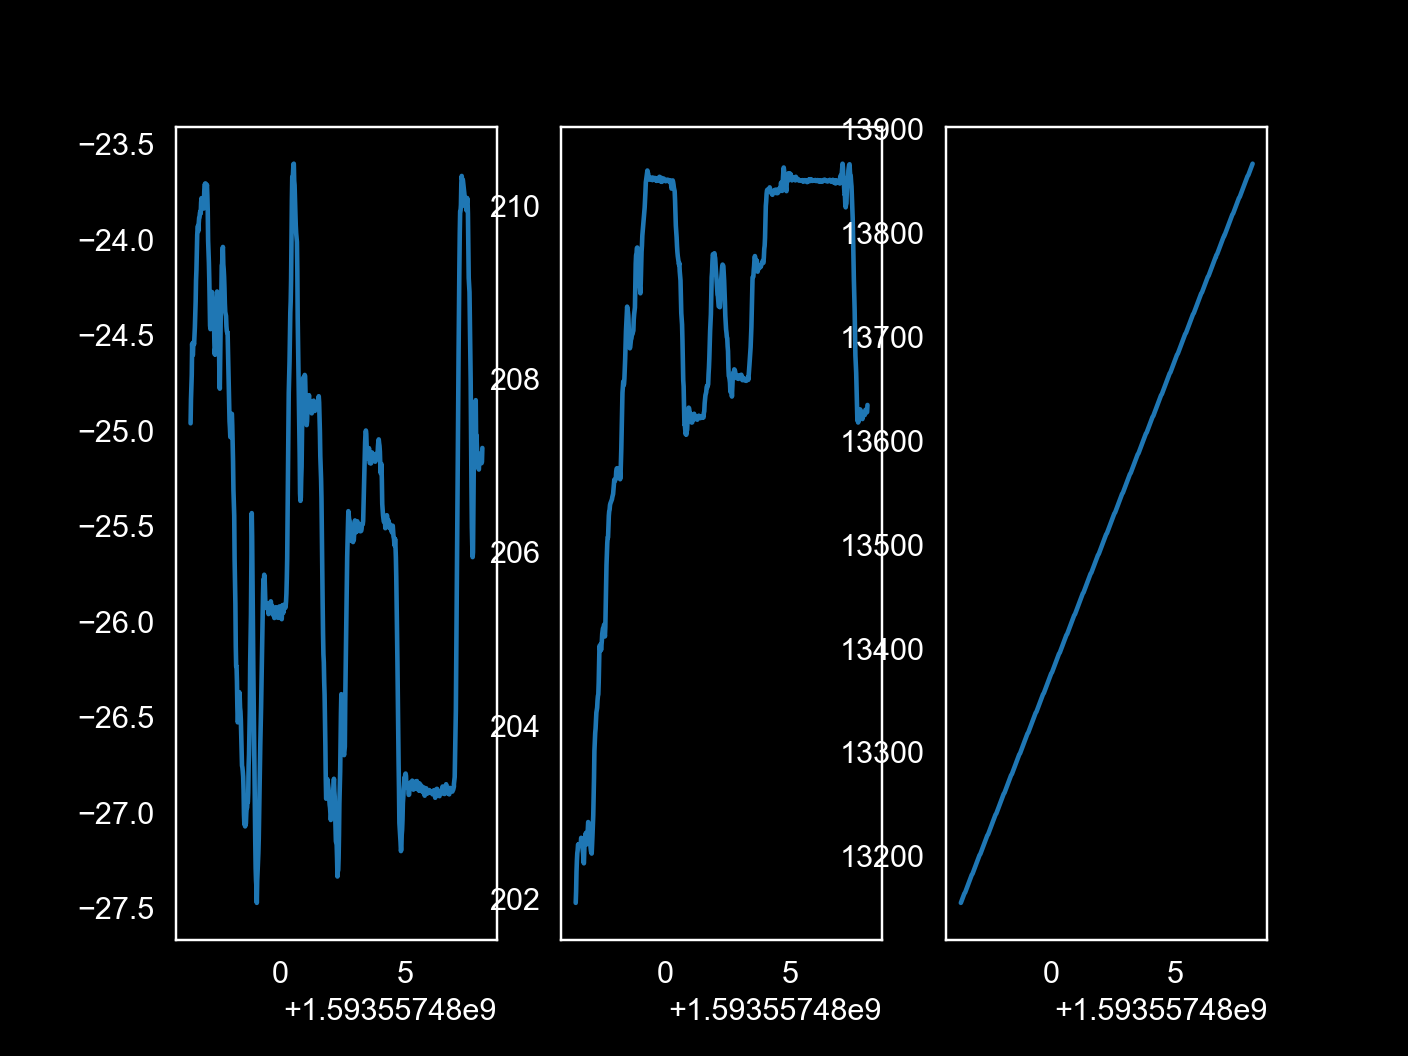

In [668]:
fig, axn =pl.subplots(1,3)
axn[0].plot(d_['time'], d_['ft_posx'])
axn[1].plot(d_['time'], d_['ft_posy'])
axn[2].plot(d_['time'], d_['ft_frame'])



In [ ]:
rundf = pd.concat(dlist)


<IPython.core.display.Javascript object>


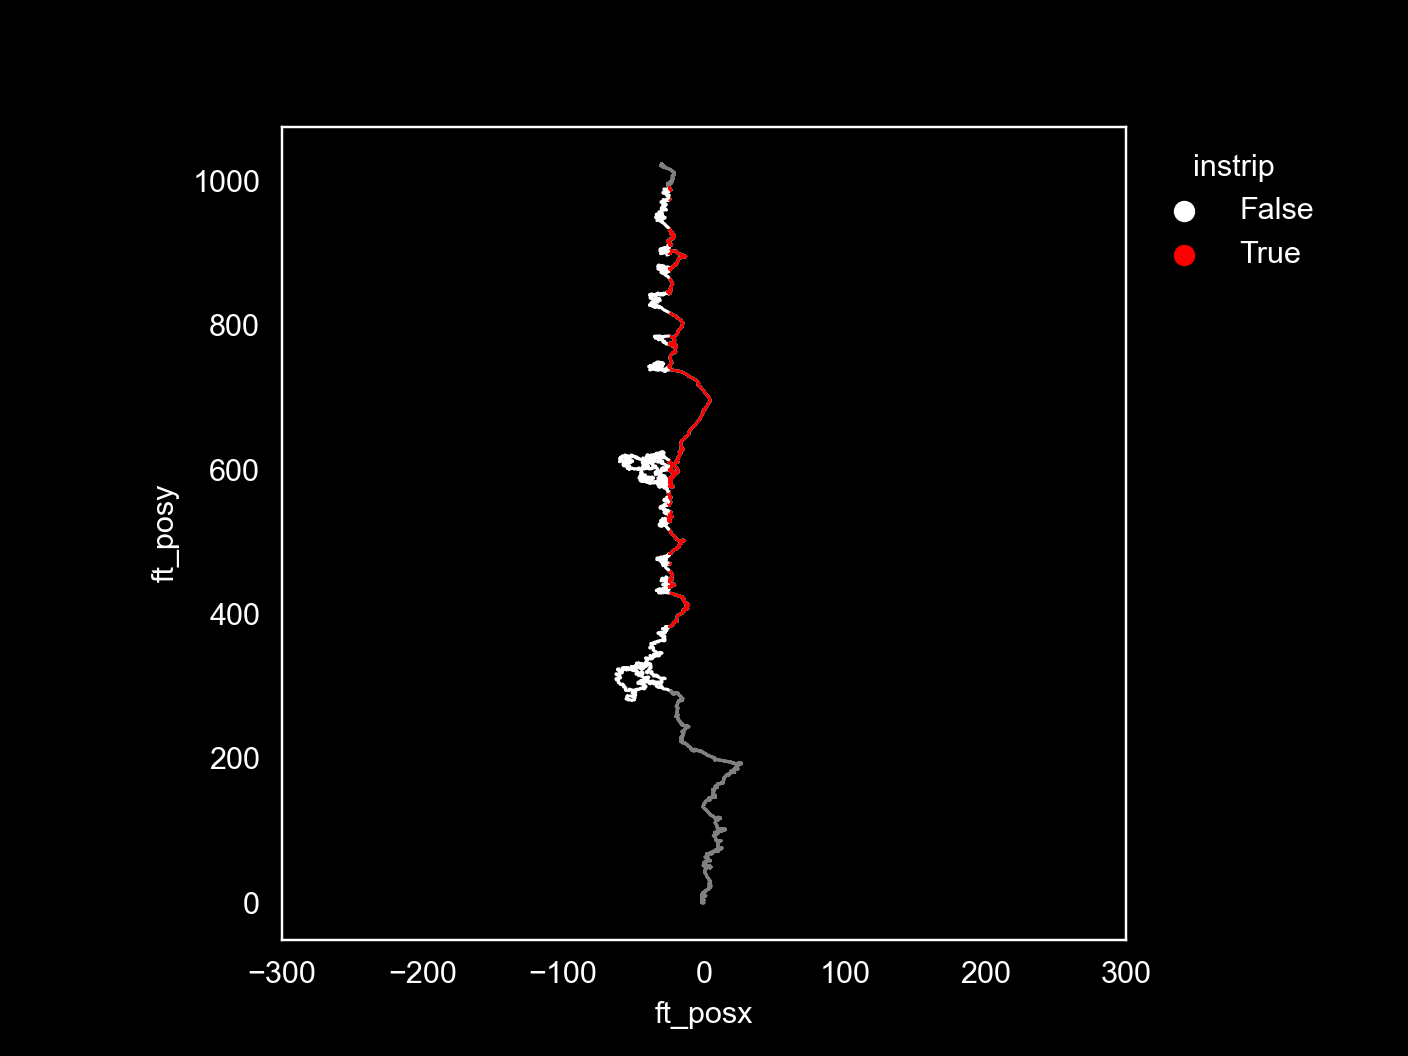

<AxesSubplot: xlabel='ft_posx', ylabel='ft_posy'>

In [502]:
fig, ax= pl.subplots()
sns.scatterplot(x='ft_posx', y='ft_posy', color='gray', data=df_, ax=ax, 
                edgecolor='none', s=1)
butil.plot_trajectory(rundf, ax=ax, center=True, plot_odor_onset=False)

In [424]:
df= df_.copy()
# entry_ix=df[df['instrip']].iloc[0].name
# from_odor_onset = df.loc[entry_ix:].copy()
# outbouts_after_entry = from_odor_onset[~from_odor_onset['instrip']]
# outbouts_after_entry

In [425]:
entry_ix=None
nprev_steps=10
if entry_ix is None:
    entry_ix = df[df['instrip']].iloc[0].name 
# check first entry *after* odor start that is also UPWIND
from_odor_onset = df.loc[entry_ix:].copy()
outbouts_after_entry = from_odor_onset[~from_odor_onset['instrip']]
#outbouts_after_entry = df[~df['instrip']].loc[entry_ix:] 
# only if last N (=20) time steps are roughly upwind (i.e., not downwind) into the strip, 
# otherwise left/right difficult to distinguish
upwind_before_entry = [b for b, b_ in outbouts_after_entry.groupby('boutnum') \
                        if b_.iloc[-nprev_steps:]['ft_posy'].diff().sum()>=-10]

In [426]:
entry_lefts=[]
for start_at_this_outbout in upwind_before_entry:
    # get first INSTRIP frame that is after the 1st odor bout and also upwind
    try:
        # get the first outbout index and the following inbout index
        exit_ix = df[df['boutnum']>=start_at_this_outbout].iloc[0].name
        df_tmp = df.loc[exit_ix:]
        test_entry_ix = df_tmp[df_tmp['instrip']].iloc[0].name
    except IndexError as e:
        # this is a second (or later) entry
        continue
    # If values are increasing, then fly is entering on strip's left edge,
    # i.e., animal enters on its right side
    s_ix = test_entry_ix - nprev_steps
    e_ix = test_entry_ix + nprev_steps*2
    cumsum = df_tmp.loc[s_ix:e_ix]['ft_posx'].diff().sum()
    #cumsum = df_tmp.loc[test_entry_ix-nprev_steps:test_entry_ix]['ft_posx'].diff().sum()
    if cumsum > 0: # entry is from LEFT of strip (values get larger)
        entry_left_edge=True
    elif cumsum < 0: # entry is into RIGHT side of strip (values get smaller)
        entry_left_edge=False
    else:
        entry_left_edge=None
    entry_lefts.append((test_entry_ix, start_at_this_outbout, entry_left_edge))


In [427]:
entry_lefts

[(3465, 2, False),
 (11563, 4, True),
 (13748, 6, True),
 (14776, 8, True),
 (16769, 10, True),
 (17951, 12, True),
 (20298, 14, True),
 (21069, 16, True),
 (21331, 18, True),
 (22237, 20, True),
 (23157, 22, True),
 (26391, 24, True),
 (32337, 26, True),
 (40443, 28, True),
 (43237, 30, True),
 (44771, 32, True),
 (47365, 34, True),
 (48245, 36, True),
 (48959, 38, True),
 (49961, 40, True),
 (50905, 42, True),
 (55021, 44, True),
 (55633, 46, True),
 (55821, 48, True)]

In [415]:
df=df_.copy()
start_at_this_outbout = 12
exit_ix = df[df['boutnum']>=start_at_this_outbout].iloc[0].name
df_tmp = df.loc[exit_ix:]
test_entry_ix = df_tmp[df_tmp['instrip']].iloc[0].name

In [421]:
s_ix = test_entry_ix - nprev_steps
e_ix = test_entry_ix + nprev_steps*2.
cumsum = df_tmp.loc[s_ix:e_ix]['ft_posx'].diff().sum()
cumsum

1.010304505832405

In [422]:
df_tmp.loc[s_ix:e_ix]['ft_posx'].diff()

17941         NaN
17942   -0.107985
17943   -0.154732
17944   -0.172505
17945   -0.255745
17946   -0.130363
17947   -0.124915
17948   -0.023665
17949   -0.010986
17950   -0.007570
17951    0.104738
17952    0.092520
17953    0.020512
17954    0.056163
17955    0.092100
17956    0.022084
17957    0.014941
17958    0.068282
17959    0.044760
17960    0.107715
17961    0.180480
17962    0.104829
17963    0.158794
17964    0.136375
17965    0.169363
17966    0.165100
17967    0.146014
17968    0.070086
17969    0.071922
17970    0.063778
17971    0.108217
Name: ft_posx, dtype: float64

<IPython.core.display.Javascript object>


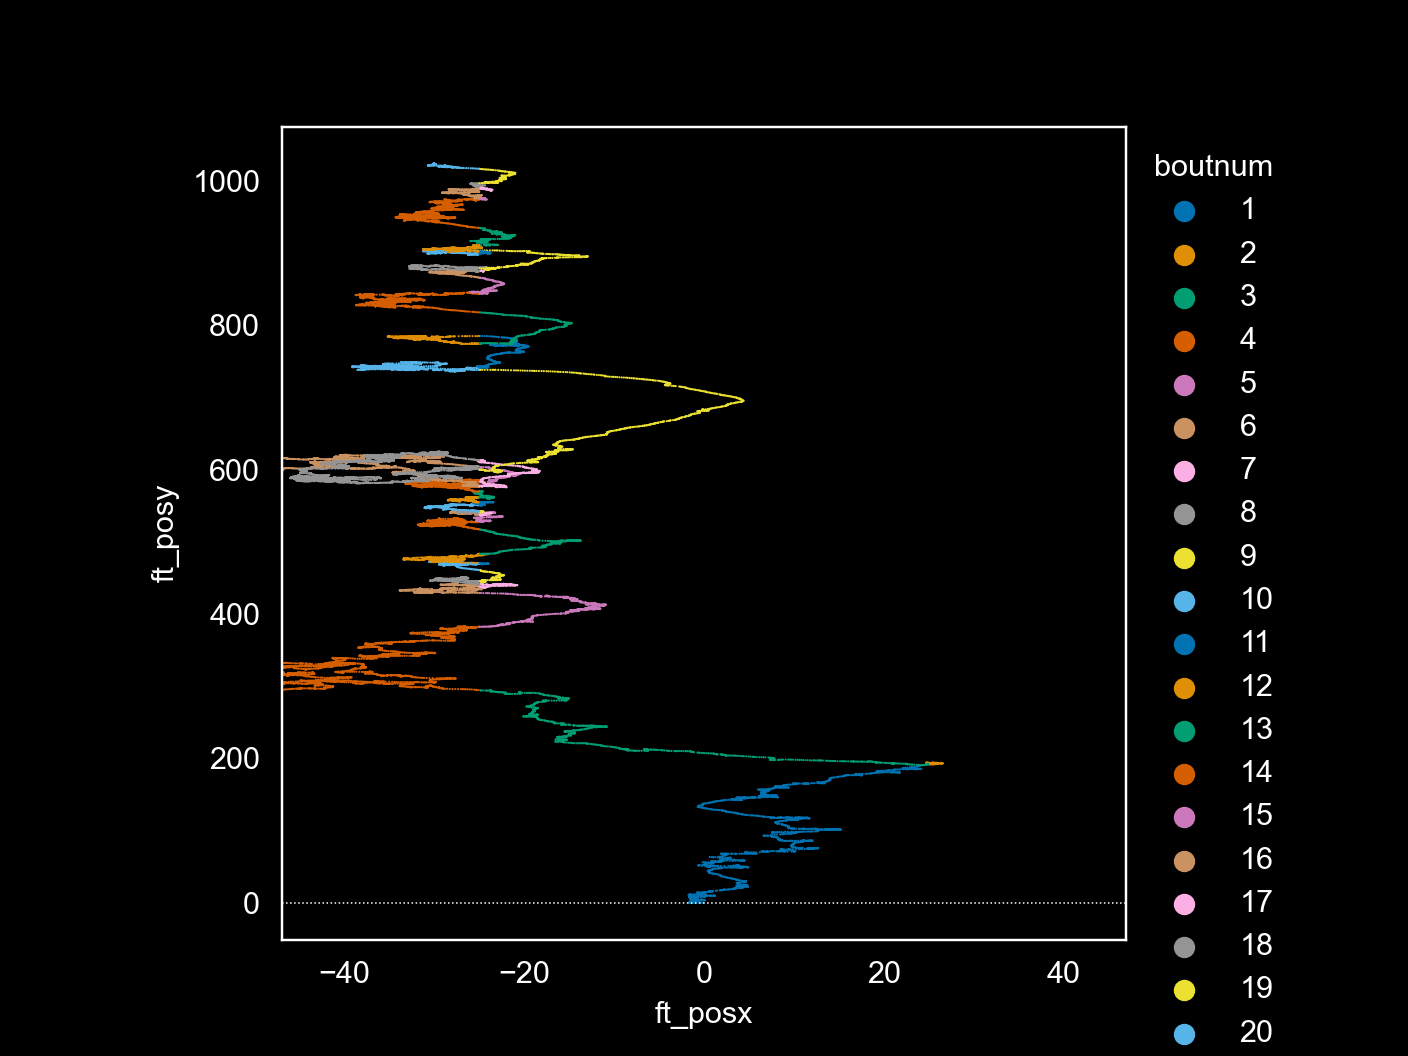

In [423]:
fig, ax = pl.subplots()
ax = butil.plot_trajectory(df_, hue_varname='boutnum', palette='colorblind', ax=ax)

In [258]:
crossover_bouts = butil.find_crossovers(df_, strip_width=strip_width)
crossover_bouts

[3]

In [263]:
importlib.reload(butil)

<module 'behavior' from '/Users/julianarhee/Repositories/plume-tracking/behavior.py'>

In [266]:
d_ = df_[df_['boutnum']>=crossover_bouts[0]].copy()
entered_left, vals = butil.check_entry_left_edge(d_, entry_ix=None, return_bool=True)
entered_left

True

In [275]:
for (v, entered_left) in vals:
    print(v, d_.loc[v]['boutnum'], entered_left)
    

3456 3 True
14776 9 True
16769 11 True
17948 13 False
20298 15 True
23157 23 True
26391 25 True
40441 29 True
43237 31 True
44771 33 True
48959 39 True
49961 41 True
50886 43 True
55021 45 True
55633 47 True
55779 49 True


In [267]:
vals

[(14776, True),
 (16769, True),
 (17948, False),
 (20298, True),
 (23157, True),
 (26391, True),
 (40441, True),
 (43237, True),
 (44771, True),
 (48959, True),
 (49961, True),
 (50886, True),
 (55021, True),
 (55633, True),
 (55779, True)]